# Spark DataFrame

* Last updated 20191015TUE1000 20170606_20170221_20161125

## S.1 학습내용

### S.1.1 목표

* Spark DataFrame을 사용할 수 있다.
* Spark SQL을 사용하여 데이터를 추출할 수 있다.
* Spark 데이터를 MongoDB에 쓰고, 읽을 수 있다.

### S.1.2 목차

* S.4 DataFrame 생성
* S.4.1 schema에서 생성하기
* S.4.2 RDD에서 생성하기
* S.4.3 Pandas
* S.4.4 csv 파일 읽기
* S.4.5 tsv 파일 읽기
* S.4.6 JSON 파일 읽기
* S.4.7 Parquet 파일 읽기, 쓰기
* S.5 DataFrame API 
* S.6 Spark SQL 
* S.7 MongoDB Spark connector
* S.7.1 설정
* S.7.2 uri 
* S.7.3 MongoDB Python API 
* S.7.4 연습으로 쓰기, 읽기
* S.8 spark-submit
* S.8.1 간단한 작업
* S.8.2 MongoDB

### S.1.3 문제

* 문제 S-1: 네트워크에 불법적으로 침입하는 사용자의 분석
* 문제 S-2: Twitter JSON 데이터 읽기
* 문제 S-3: 뉴욕에서 출생한 신생아 분석
* 문제 S-4: 우버 택시의 운행기록 분석
* 문제 S-5: JDBC를 사용해서 데이터 읽기
* 문제 S-6: MongoDB 저장된 열린데이터 읽어오는 spark-submit

## S.2 IPython Notebook에서 SparkSession 생성하기

Spark가 설치된 디렉토리를 SPARK_HOME으로 설정하고, 실행에 필요한 'py4j-0.10.1-src.zip', 'pyspark.zip' 라이브러리를 추가한다.

In [2]:
import os
import sys
os.environ["SPARK_HOME"]=os.path.join(os.environ['HOME'],'Downloads','spark-2.0.0-bin-hadoop2.7')
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

Spark를 사용하려면 ```SparkSession``` 객체를 생성해야 한다.

줄 | 설명
-----|-----
1 | pyspark 라이브러리 가져오기
2 | SparkSession에 필요한 설정을 넣어서 만들어 준다. 설정은 SparkSession이 만들지기 전에 해 두어야 한다. 여기서는 설정을 별도로 하지 않고 비워 놓았다.
3 | SparkSession은 ```getOrCreate()```로 이미 만들어져 있으면 현재 것을, 없으면 생성하는 방식을 취하고 있다.

In [1]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [2]:
print spark.version

2.2.0


## S.3 DataFrame

### 특징

DataFrame은 **행, 열로 구조화**된 데이터구조이다.
관계형데이터베이스 RDB의 테이블이나 엑셀 쉬트sheet와 비슷하다.
또는 Pandas 또는 R을 사용해 보았다면 거기서 제공되는 DataFrame과 유사하다.
Apache Spark 1.0에서는 **SchemaRDD**라는 명칭으로 시험적으로 제공되었다. 이름에서 보듯이 RDD에 스키마를 얹어서 만든 개념이다.
그러나 Spark의 DataFrame은 **대용량 데이터를 하기 위해 만들어진 프레임워크로 분산**해서 사용할 수 있게 고안되었다.


앞서 사용했던 **RDD가 schema를 정하지 않는** 것과 달리, **DataFrame은 모델 schema**를 설정해서 사용을 한다. '열'에 대해 명칭 및 **데이터 타잎**을 가지고 있고, 이를 지켜서 데이터를 저장하게 된다. 

### DataFrame의 Schema

**Column**은 DataFrame의 **열**이고, **데이터 타잎**을 가진다.
**Row**는 DataFrame의 행으로, 데이터 요소항목을 묶어서 구성한다. **Python list나 dict**를 사용하여 Row를 구성할 수 있다.

**데이터 타잎**은 다음과 같다.

```python
NullType
StringType
BinaryType
BooleanType
DateType
TimestampType
DoubleType
DecimalType
ShortType
ArrayType
MapType
```

### DataFrame 주요 API

RDD와 마찬가지로 DataFrame을 구성하여 **머신러닝**의 입력데이터로 사용할 수 있다.
현재 버전 2.0부터 RDD에 대한 지원은 줄여나가고, **버전 3.0 이후에는 DataFrame API를 공식적으로 지원**한다고 발표한 바 있다. RDD보다 우선적으로 사용하는 것이 좋겠다.

기능 | 설명 | 예제
-------|-------|-------
```json``` | json 읽기 | ```spark.read.json("employee.json")```
```show``` | 데이터 읽기 | ```df.show()```
```schema``` | 데이터 schema 보기 | ```df.printSchema()```
```select``` | 열을 선택 | ```df.select("name")```
```filter``` | 조건 선택 | ```df.filter(dfs("age") > 23).show()```
```groupBy``` | 그룹 | ```df.groupBy("age").count().show()```
```dropna``` | na를 삭제 | ```df.dropna()``` ```df.na.drop()```
```fillna``` | na를 값으로 채우기 | ```fillna()```
```count``` | 행 세기 | ```df.count()```
```drop``` | 삭제 | ```df.drop("name")```


## S.4 DataFrame 생성

DataFrame은 관계형데이터베이스 RDB 테이블과 같이, schema를 정해서 생성한다.
**schema를 정해주지 않으면, Spark가 자동으로 유추**하게 된다.
RDD와 같이, 외부 파일 또는 배열과 같은 자료구조에서 읽어서 생성하고, 생성된 DataFrame은 분산하여 처리할 수 있게 된다.

생성 방법 | 설명 | 함수
----------|----------|----------
**외부**에서 읽기 | Hive, csv, JSON, RDB, XML, Parquet, Apache Cassandra, RDD 등 | **```spark.createDataFrame()```** 또는 **```spark.read()```**
**내부**에서 읽기 | Python list, dict 또는 ```pyspark.sql.Row``` 객체를 사용해서 한 줄씩 만들 수 있다. | **```spark.createDataFrame()```**

### S.4.1 schema로 생성하기

schema는 모델을 말한다. 데이터의 컬럼의 명칭과 데이터타잎을 정해야 한다.


#### 자동으로 인식하는 schema

우선 단순하게 Python 자료구조를 사용해서 생성해 본다.
아래 열이 3개인 데이터를 **```createDataFrame()```** 함수를 사용하여 넣어 보자.

In [3]:
myList=[('1','kim, js',170),
        ('1','lee, sm', 175),
        ('2','lim, yg',180),
        ('2','lee',170)]

In [4]:
myDf=spark.createDataFrame(myList)

이 경우 Spark가 **자동으로 schema를 설정**한다.
```printSchema()``` 함수로 schema를 출력해 보기로 하자.
* **컬럼**명은 **일련번호**를 가지고 생성된다. schema를 정하지 않았으므로, 열은 '_1', '_2'와 같이 명명된다.
* **데이터 타잎**도 유추해서 생성한다. 올바르게 되지 않을 경우도 있다는 점에 유의한다. 아래에서 보듯이 처음 수는 ```String``` 다음 이름은 ```String``` 키는 ```long```으로 인식하고 있다.

In [5]:
myDf.printSchema()
print myDf.take(1)

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)

[Row(_1=u'1', _2=u'kim, js', _3=170)]


#### 컬럼명 설정

앞서 컬럼 Column을 정의하지 않고 DataFrame을 생성하였는데, 이번에는 **컬럼을 정해서** 생성하자.
**```createDataFrame()```** 함수에 **인자로 컬럼명을 리스트 ```['year','name','height']```로** 정해준다.

In [6]:
print spark.createDataFrame(myList, ['year','name','height']).take(1)

[Row(year=u'1', name=u'kim, js', height=170)]


간단한 연산식으로 데이터 100개를 생성해 보자.
Python list인 names, items 배열에서 **modulus**를 활용하여 하나씩 선택하여 데이터를 생성한다.
**names**는 4개이므로 4로 나눈 나머지와 **items**는 6개이므로 6으로 나눈 나머지를 하나씩 선택하고 있다.
그리고 컬럼명을 ```["name","item"]```으로 정한다.

In [11]:
names = ["kim","lee","lee","lim"]
items = ["espresso","latte","americano","affocato","long black","macciato"]
df = spark.createDataFrame([(names[i%4], items[i%6]) for i in range(100)],\
                           ["name","item"])
df.show(10)

+----+----------+
|name|      item|
+----+----------+
| kim|  espresso|
| lee|     latte|
| lee| americano|
| lim|  affocato|
| kim|long black|
| lee|  macciato|
| lee|  espresso|
| lim|     latte|
| kim| americano|
| lee|  affocato|
+----+----------+
only showing top 10 rows



컬럼을 골라내어 **```select()```**할 수 있다.
* **```item```** 열의 **```substr```**으로 1,3문자를 선택
* **```alias```**로 **컬럼명**을 정할 수 있다.

In [12]:
df.select(df.item.substr(1, 3).alias("short name")).show(3)

+----------+
|short name|
+----------+
|       esp|
|       lat|
|       ame|
+----------+
only showing top 3 rows



#### Row 객체를 사용해서 생성

**Row**를 사용해 보자.
Row는 **이름(Column)이 붙여진 행**으로 **관계형데이터베이스 레코드 Record**와 같다. 
속성 명은 'year', 'name', 'height'로 명명한다.

In [7]:
from pyspark.sql import Row
Person = Row('year','name', 'height')
row1=Person('1','kim, js',170)

속성명을 읽을 때에는 **```row.key```** 또는 Python dict형식으로 **```row[key]```**와 같이 속성을 읽을 수 있다.

In [8]:
print "row1: ", row1.year, row1.name

row1:  1 kim, js


위에서 설정한 Row를 사용하여 DataFrame을 만들어 보자.
**Python list에 Row를 넣어** 구성한다.
첫번째는 앞서 만든 row1 객체를 넣을 수 있다.

In [9]:
myRows = [row1,
          Person('1','lee, sm', 175),
          Person('2','lim, yg',180),
          Person('2','lee',170)]

In [10]:
myDf=spark.createDataFrame(myRows)

printSchema()를 해보면, **데이터 타잎**은 string, long으로 Spark에서 **자동** 인식되었다는 것을 알 수 있다.

In [11]:
print myDf.printSchema()
myDf.show()

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: long (nullable = true)

None
+----+-------+------+
|year|   name|height|
+----+-------+------+
|   1|kim, js|   170|
|   1|lee, sm|   175|
|   2|lim, yg|   180|
|   2|    lee|   170|
+----+-------+------+



#### schema를 정의하고 생성

모델 schema를 정하고, **데이터 타잎**을 정의해 DataFrame을 생성해 본다.
**```StructType```**으로 구조체를 선언하고, 컬럼에 대해 **```StructField```**를 설정한다.
* **컬럼**의 명칭
* 앞서 소개했던 **데이터 타잎**
* 마지막은 **NULL**이 허용되는지 여부

```python
StructType([
    StructField(컬럼명, StringType(), True),
    ...
])
```

In [18]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType
mySchema=StructType([
    StructField("year", StringType(), True),
    StructField("name", StringType(), True),
    StructField("height", IntegerType(), True)
])

앞서 **myRows**를 데이터로, **mySchema**에서는 컬럼 명과 데이터타잎을 정의하여 ```createDataFrame()```함수의 인자로 넘겨주고 있다.

In [19]:
myDf=spark.createDataFrame(myRows, mySchema)
myDf.printSchema()
myDf.take(1)

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)



[Row(year=u'1', name=u'kim, js', height=170)]

### S.4.2 RDD에서 생성하기

RDD는 schema가 정해지지 않은 비구조적 데이터이다.
이와 같이 **schema를 정의하지 않으면, Spark는 schema를 유추**하게 된다.


#### schema 자동 인식

RDD로부터 DataFrame을 생성할 수 있다. 이 경우 schema를 설정하지 않으면 자동으로 인식된다.

In [20]:
from pyspark.sql import Row

myList=[('1','kim, js',170),('1','lee, sm', 175),('2','lim, yg',180),('2','lee',170)]

In [21]:
myRdd = spark.sparkContext.parallelize(myList)

```toDF()```로 변환하거나 직접 ```createDataFrame()``` 함수를 사용하여 DataFrame을 생성할 수 있다.

In [22]:
rddDf=myRdd.toDF()
rddDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)



In [23]:
rddDf=spark.createDataFrame(myRdd)
rddDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)



DataFrame은 관계형데이터베이스의 테이블과 매우 유사하다. **SQL 명령**을 사용하듯이 ```where()```, ```select()```, ```groupby()``` 함수를 사용할 수 있다.

In [24]:
rddDf.where(rddDf._3 < 175)\
    .select([rddDf._1, rddDf._2])\
    .show()

+---+-------+
| _1|     _2|
+---+-------+
|  1|kim, js|
|  2|    lee|
+---+-------+



```groupBy()```하면 행의 값으로 구분지어서 평균, 합계, 갯수, 최대, 최소 등을 구할 수 있다.
첫 컬럼을 ```groupby()```해서 최대값 ```max()```를 구해보자.

In [25]:
rddDf.groupby(rddDf._1).max().show()

+---+-------+
| _1|max(_3)|
+---+-------+
|  1|    175|
|  2|    180|
+---+-------+



#### Row를 사용

학년year는 앞에서는 **string**으로 인식되었다. 이번 예제에서는 **형변환**을 해 본다.
RDD의 ```map()``` 함수를 사용하여 각 속성을 읽고 ```int()``` 함수로 형변환을 한다.
각 속성에 명칭, year, name, height를 설정한다.

In [26]:
_myRdd=myRdd.map(lambda x:Row(year=int(x[0]),name=x[1],height=int(x[2])))

In [27]:
_myDf=spark.createDataFrame(_myRdd)
_myDf.printSchema()
_myDf.take(1)

root
 |-- height: long (nullable = true)
 |-- name: string (nullable = true)
 |-- year: long (nullable = true)



[Row(height=170, name=u'kim, js', year=1)]

```Row()```를 사용하여 RDD를 생성할 수도 있다.

In [28]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType, TimestampType
r1=Row(name="js1",age=10)
r2=Row(name="js2",age=20)
_myRdd=spark.sparkContext.parallelize([r1,r2])

In [29]:
_myRdd.collect()

[Row(age=10, name='js1'), Row(age=20, name='js2')]

####  schema를 정의하고 생성

앞서 보았듯이, schema를 정의하고 RDD에서 DataFrame을 생성할 수 있다.
**```StructType```**을 선언하고,
컬럼에 대해 **```StructField```**를 **컬럼명**, **데이터 타잎**, **NULL**이 허용되는지 여부를 설정한다.
단, 컬럼명이 정렬되면서 age, name 순서가 변경된다.

In [30]:
schema=StructType([
    StructField("age", IntegerType(), True),
    StructField("name", StringType(), True),
    #StructField("created", TimestampType(), True)
])
_myDf=spark.createDataFrame(_myRdd,schema)
_myDf.printSchema()
_myDf.show()

root
 |-- age: integer (nullable = true)
 |-- name: string (nullable = true)

+---+----+
|age|name|
+---+----+
| 10| js1|
| 20| js2|
+---+----+



* schema를 정해서 RDD로부터 DataFrame을 생성할 수 있다.


In [31]:
from pyspark.sql.types import *
myRdd=spark.sparkContext.parallelize([(1, 'kim', 50.0), (2, 'lee', 60.0), (3, 'park', 70.0)])
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("height", DoubleType(), True)
])
_myDf = spark.createDataFrame(myRdd, schema)
_myDf.printSchema()
_myDf.show()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: double (nullable = true)

+---+----+------+
| id|name|height|
+---+----+------+
|  1| kim|  50.0|
|  2| lee|  60.0|
|  3|park|  70.0|
+---+----+------+



## S.4.3 Pandas

Spark Dataframe은 다른 프로그래밍 언어에서도 분석도구로 많이 사용되는 형식이다.
엑셀 스프레드쉬트와 비슷하다. 또한 최근 많이 사용되는 **R**의 Dataframe이나 **Python Pandas**를 예로 들 수 있다.
Spark와 Pandas의 Dataframe을 비교하면,
**Pandas**는 데이터 양이 적은 경우, Spark는 분산처리할 수 있으므로 빅데이터에 보다 적합하다.
API를 사용하게 되면 Spark Dataframe과 Pandas 간에는 차이가 있다.

DataFrame | Spark | Pandas
-------|-------|-------
csv file | map split(',') | read_csv()
| show() | head(), tail()
data types | 맞게 추정 | 모두 strings

### Dataframe을 Pandas로 변환

Spark Dataframe을 ```toPandas()``` 함수를 사용하여 **Pandas로 변환**할 수 있다.

In [32]:
myDf.toPandas()

,year,name,height
0,1,"kim, js",170
1,1,"lee, sm",175
2,2,"lim, yg",180
3,2,lee,170


### Pandas에서 csv 쓰기

Dataframe을 **csv**파일로 내보내고 Pandas로 읽어보자.

Dataframe을 csv로 쓰려면 라이브러리 ```com.databricks.spark.csv```를 사용해야 한다. **단일 파일이 아니라 디렉토리가 생성**되고 그 안에 여러 파일로 쓰여지게 된다. Pandas를 사용하면 우리가 보통 사용하는 하나의 파일로 쓰여진다.

```python
-rw-r--r-- 1 jsl jsl 16 10월  5 15:42 part-r-00000-1b8b272e-7590-4e73-bd51-27d12ffa5d88.csv
-rw-r--r-- 1 jsl jsl 16 10월  5 15:42 part-r-00001-1b8b272e-7590-4e73-bd51-27d12ffa5d88.csv
-rw-r--r-- 1 jsl jsl 16 10월  5 15:42 part-r-00002-1b8b272e-7590-4e73-bd51-27d12ffa5d88.csv
-rw-r--r-- 1 jsl jsl 10 10월  5 15:42 part-r-00003-1b8b272e-7590-4e73-bd51-27d12ffa5d88.csv
-rw-r--r-- 1 jsl jsl  0 10월  5 15:42 _SUCCESS
```

In [34]:
myDf.write.format('com.databricks.spark.csv').save(os.path.join('data','_myDf.csv'))

In [35]:
!ls data/_myDf.csv/

part-r-00000-1b8b272e-7590-4e73-bd51-27d12ffa5d88.csv
part-r-00001-1b8b272e-7590-4e73-bd51-27d12ffa5d88.csv
part-r-00002-1b8b272e-7590-4e73-bd51-27d12ffa5d88.csv
part-r-00003-1b8b272e-7590-4e73-bd51-27d12ffa5d88.csv
_SUCCESS


Pandas를 이용하여 Dataframe을 csv파일로 내보낼 수 있다.

```python
,year,name,height
0,1,"kim, js",170
1,1,"lee, sm",175
2,2,"lim, yg",180
3,2,lee,170
```

In [36]:
myDf.toPandas().to_csv(os.path.join('data','myDf.csv'))

### Pandas에서 JSON 읽기

트위터 데이터는 JSON 형식을 가지고 있다.
아래는 트윗 1개의 샘플이다.
실제 트윗 데이터를 구할 수 없다면 아래 샘플을 파일로 저장한 후 사용하면 된다.

```python
{"contributors": null, "truncated": false, "text": "RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, And Leeteuk To MC For 2016 Super Seoul Dream Concert \nhttps://t.co/1XRSaRBbE0 https://t.co/fi…", "is_quote_status": false, "in_reply_to_status_id": null, "id": 801657325836763136, "favorite_count": 0, "entities": {"symbols": [], "user_mentions": [{"id": 17659206, "indices": [3, 10], "id_str": "17659206", "screen_name": "soompi", "name": "Soompi"}], "hashtags": [{"indices": [12, 22], "text": "SEVENTEEN"}], "urls": [{"url": "https://t.co/1XRSaRBbE0", "indices": [100, 123], "expanded_url": "http://www.soompi.com/2016/11/20/seventeens-mingyu-jin-se-yeon-leeteuk-mc-dream-concert/", "display_url": "soompi.com/2016/11/20/sev…"}]}, "retweeted": false, "coordinates": null, "source": "<a href=\"http://twitter.com/download/android\" rel=\"nofollow\">Twitter for Android</a>", "in_reply_to_screen_name": null, "in_reply_to_user_id": null, "retweet_count": 1487, "id_str": "801657325836763136", "favorited": false, "retweeted_status": {"contributors": null, "truncated": false, "text": "#SEVENTEEN’s Mingyu, Jin Se Yeon, And Leeteuk To MC For 2016 Super Seoul Dream Concert \nhttps://t.co/1XRSaRBbE0 https://t.co/fifXHpF8or", "is_quote_status": false, "in_reply_to_status_id": null, "id": 800593781586132993, "favorite_count": 1649, "entities": {"symbols": [], "user_mentions": [], "hashtags": [{"indices": [0, 10], "text": "SEVENTEEN"}], "urls": [{"url": "https://t.co/1XRSaRBbE0", "indices": [88, 111], "expanded_url": "http://www.soompi.com/2016/11/20/seventeens-mingyu-jin-se-yeon-leeteuk-mc-dream-concert/", "display_url": "soompi.com/2016/11/20/sev…"}], "media": [{"expanded_url": "https://twitter.com/soompi/status/800593781586132993/photo/1", "display_url": "pic.twitter.com/fifXHpF8or", "url": "https://t.co/fifXHpF8or", "media_url_https": "https://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg", "id_str": "800593115165798400", "sizes": {"small": {"h": 382, "resize": "fit", "w": 680}, "large": {"h": 449, "resize": "fit", "w": 800}, "medium": {"h": 449, "resize": "fit", "w": 800}, "thumb": {"h": 150, "resize": "crop", "w": 150}}, "indices": [112, 135], "type": "photo", "id": 800593115165798400, "media_url": "http://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg"}]}, "retweeted": false, "coordinates": null, "source": "<a href=\"https://about.twitter.com/products/tweetdeck\" rel=\"nofollow\">TweetDeck</a>", "in_reply_to_screen_name": null, "in_reply_to_user_id": null, "retweet_count": 1487, "id_str": "800593781586132993", "favorited": false, "user": {"follow_request_sent": false, "has_extended_profile": true, "profile_use_background_image": true, "default_profile_image": false, "id": 17659206, "profile_background_image_url_https": "https://pbs.twimg.com/profile_background_images/699864769/1cdde0a85f5c0a994ae1fb06d545a5ec.png", "verified": true, "translator_type": "none", "profile_text_color": "999999", "profile_image_url_https": "https://pbs.twimg.com/profile_images/792117259489583104/4khJk3zz_normal.jpg", "profile_sidebar_fill_color": "000000", "entities": {"url": {"urls": [{"url": "http://t.co/3evT80UlR9", "indices": [0, 22], "expanded_url": "http://www.soompi.com", "display_url": "soompi.com"}]}, "description": {"urls": []}}, "followers_count": 987867, "profile_sidebar_border_color": "000000", "id_str": "17659206", "profile_background_color": "1E1E1E", "listed_count": 3982, "is_translation_enabled": true, "utc_offset": -28800, "statuses_count": 80038, "description": "The original K-pop community. We take gifs, OTPs, and reporting on your bias' fashion choices seriously. But not rumors. Ain't nobody got time for that.", "friends_count": 3532, "location": "Worldwide", "profile_link_color": "31B6F4", "profile_image_url": "http://pbs.twimg.com/profile_images/792117259489583104/4khJk3zz_normal.jpg", "following": false, "geo_enabled": false, "profile_banner_url": "https://pbs.twimg.com/profile_banners/17659206/1478803767", "profile_background_image_url": "http://pbs.twimg.com/profile_background_images/699864769/1cdde0a85f5c0a994ae1fb06d545a5ec.png", "screen_name": "soompi", "lang": "en", "profile_background_tile": true, "favourites_count": 1493, "name": "Soompi", "notifications": false, "url": "http://t.co/3evT80UlR9", "created_at": "Wed Nov 26 20:48:27 +0000 2008", "contributors_enabled": false, "time_zone": "Pacific Time (US & Canada)", "protected": false, "default_profile": false, "is_translator": false}, "geo": null, "in_reply_to_user_id_str": null, "possibly_sensitive": false, "lang": "en", "created_at": "Mon Nov 21 06:56:46 +0000 2016", "in_reply_to_status_id_str": null, "place": null, "extended_entities": {"media": [{"expanded_url": "https://twitter.com/soompi/status/800593781586132993/photo/1", "display_url": "pic.twitter.com/fifXHpF8or", "url": "https://t.co/fifXHpF8or", "media_url_https": "https://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg", "id_str": "800593115165798400", "sizes": {"small": {"h": 382, "resize": "fit", "w": 680}, "large": {"h": 449, "resize": "fit", "w": 800}, "medium": {"h": 449, "resize": "fit", "w": 800}, "thumb": {"h": 150, "resize": "crop", "w": 150}}, "indices": [112, 135], "type": "photo", "id": 800593115165798400, "media_url": "http://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg"}]}, "metadata": {"iso_language_code": "en", "result_type": "recent"}}, "user": {"follow_request_sent": false, "has_extended_profile": false, "profile_use_background_image": true, "default_profile_image": true, "id": 791090169818521600, "profile_background_image_url_https": null, "verified": false, "translator_type": "none", "profile_text_color": "333333", "profile_image_url_https": "https://abs.twimg.com/sticky/default_profile_images/default_profile_6_normal.png", "profile_sidebar_fill_color": "DDEEF6", "entities": {"description": {"urls": []}}, "followers_count": 0, "profile_sidebar_border_color": "C0DEED", "id_str": "791090169818521600", "profile_background_color": "F5F8FA", "listed_count": 0, "is_translation_enabled": false, "utc_offset": null, "statuses_count": 96, "description": "", "friends_count": 7, "location": "", "profile_link_color": "1DA1F2", "profile_image_url": "http://abs.twimg.com/sticky/default_profile_images/default_profile_6_normal.png", "following": false, "geo_enabled": false, "profile_background_image_url": null, "screen_name": "enriquesanq", "lang": "es", "profile_background_tile": false, "favourites_count": 161, "name": "Enrique santos", "notifications": false, "url": null, "created_at": "Wed Oct 26 01:32:49 +0000 2016", "contributors_enabled": false, "time_zone": null, "protected": false, "default_profile": true, "is_translator": false}, "geo": null, "in_reply_to_user_id_str": null, "possibly_sensitive": false, "lang": "en", "created_at": "Thu Nov 24 05:22:55 +0000 2016", "in_reply_to_status_id_str": null, "place": null, "metadata": {"iso_language_code": "en", "result_type": "recent"}}
```

그러나 JSON파일은 **JSON이 아니라 문자열**이다. 파일에서 읽은 후 **JSON으로 변환**을 해야 한다.
트윗은 '\n'으로 하나씩 구분되어 있고 ```readlines()``` 함수로 전체를 읽을 수 있다.

In [37]:
import os
_jfname=os.path.join('src','ds_twitter_seoul_3.json')
with open(_jfname, 'rb') as f:
    data = f.readlines()

문자열  양끝에 붙어있을 수 있는 문자를 ```rstrip()```으로 제거한다. 매개변수가 없으면 whitespace를 제거한다.

> whitespace

> 스페이스바, 탭, RETURN, ENTER 키를 말한다.


In [38]:
data = map(lambda x: x.rstrip(), data)

위 Tweet데이터는 json형식이다. 따라서 list 구조로 만들어 주려면, 앞 뒤로 대괄호 ```[ ]```를 넣고, 각 tweet은 컴마로 연결한다.
```join()``` 함수는 인자를 구분자 ","로 병합한다.

```python
",".join(["A", "B", "C"]) # A,B,C
```

In [39]:
data_json_str = "[" + ','.join(data) + "]"

아직 JSON으로 변환이 되지 않았고, **문자열 전체 길이**를 알아 보자. 파일의 크기를 알 수 있다.

In [40]:
len(data_json_str)

11308455

이제 Pandas로 읽어 보자.
Pandas 라이브러리에서 제공하는 ```read_json()```함수를 사용한다.

In [41]:
import pandas as pd

data_df = pd.read_json(data_json_str)

```shape()```은 행과 열의 갯수를 알려준다. ```count()``` 함수는 행의 갯수를 나타내는데, 숫자가 서로 다른 것은 비워있는 경우가 서로 다르기 때문이다.

In [42]:
print data_df.count()

contributors                    0
coordinates                    55
created_at                   2013
entities                     2013
extended_entities             506
favorite_count               2013
favorited                    2013
geo                            55
id                           2013
id_str                       2013
in_reply_to_screen_name       153
in_reply_to_status_id         131
in_reply_to_status_id_str     131
in_reply_to_user_id           153
in_reply_to_user_id_str       153
is_quote_status              2013
lang                         2013
metadata                     2013
place                          65
possibly_sensitive           1097
quoted_status                  19
quoted_status_id              133
quoted_status_id_str          133
retweet_count                2013
retweeted                    2013
retweeted_status             1304
source                       2013
text                         2013
truncated                    2013
user          

Spark dataframe과 같이 데이터를 생성하였고, 'id'속성을 10개만 읽어 보자.

In [28]:
data_df['id'][:10]

0    801657325836763136
1    801657325677400064
2    801657307637678080
3    801657305628430336
4    801657297449586688
5    801657287697895424
6    801657280760397824
7    801657276788523008
8    801657268177604608
9    801657258400616449
Name: id, dtype: int64

### S.4.4 csv 파일에서 생성

Spark examples 폴더에 있는 아래 내용의 ```people.txt```를 읽어보자.
```python
Michael, 29
Andy, 30
Justin, 19
```

```sparkContext.textFile()``` 함수로 읽은 파일은 RDD이다.

In [29]:
from pyspark.sql import Row
cfile= os.path.join(os.environ["SPARK_HOME"],\
           "examples/src/main/resources/people.txt")
lines = spark.sparkContext.textFile(cfile)

RDD에서 ```Row()```를 사용하여 Dataframe으로 변환한다.

In [30]:
parts = lines.map(lambda l: l.split(","))
people = parts.map(lambda p: Row(name=p[0], age=int(p[1].strip())))

_myDf = spark.createDataFrame(people)

In [31]:
_myDf.printSchema()
_myDf.collect()

root
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



[Row(age=29, name=u'Michael'),
 Row(age=30, name=u'Andy'),
 Row(age=19, name=u'Justin')]

#### DataFrame으로 직접 읽기

csv 패키지를 사용해서 읽어 본다. 우선 [Spark의 csv 패키지를 추가한다.](https://spark-packages.org/package/databricks/spark-csv) 패키지는 설정파일 ```spark-defaults.conf```에 추가할 수 있다.

```python
$ vim conf/spark-defaults.conf
spark.jars.packages=com.databricks:spark-csv_2.11:1.5.0
```


In [28]:
%%writefile data/ds_spark.csv
1,2,3,4
11,22,33,44
111,222,333,444

Overwriting data/ds_spark.csv


In [32]:
df = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/ds_spark.csv')
df.show()


+---+---+---+---+
|  1|  2|  3|  4|
+---+---+---+---+
| 11| 22| 33| 44|
|111|222|333|444|
+---+---+---+---+



### S.4.5 tsv 파일 읽기

tsv는 **Tab으로 분리된 파일**을 말한다. '\t'이 포함되어 있는 경우, Spark는 string으로 데이터타잎을 설정한다.

In [6]:
import numpy as np
np.array([float(x) for x in '1.658985	4.285136'.split('\t')])

array([ 1.658985,  4.285136])

In [4]:
import numpy as np
np.array([float(x) for x in '1.658985 4.285136'.split(' ')])

array([ 1.658985,  4.285136])

* 데이터 출처: http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights
    * 마우스로 긁어서 50행만 복사

In [ ]:
# %load data/ds_spark_heightweight.txt
1	65.78	112.99
2	71.52	136.49
3	69.40	153.03
4	68.22	142.34
5	67.79	144.30
6	68.70	123.30
7	69.80	141.49
8	70.01	136.46
9	67.90	112.37
10	66.78	120.67
11	66.49	127.45
12	67.62	114.14
13	68.30	125.61
14	67.12	122.46
15	68.28	116.09
16	71.09	140.00
17	66.46	129.50
18	68.65	142.97
19	71.23	137.90
20	67.13	124.04
21	67.83	141.28
22	68.88	143.54
23	63.48	97.90
24	68.42	129.50
25	67.63	141.85
26	67.21	129.72
27	70.84	142.42
28	67.49	131.55
29	66.53	108.33
30	65.44	113.89
31	69.52	103.30
32	65.81	120.75
33	67.82	125.79
34	70.60	136.22
35	71.80	140.10
36	69.21	128.75
37	66.80	141.80
38	67.66	121.23
39	67.81	131.35
40	64.05	106.71
41	68.57	124.36
42	65.18	124.86
43	69.66	139.67
44	67.97	137.37
45	65.98	106.45
46	68.67	128.76
47	66.88	145.68
48	67.70	116.82
49	69.82	143.62
50	69.09	134.93

* tsv는 '\t'로 분리해야 한다.

In [14]:
from pyspark.sql.types import *
rdd=spark.sparkContext\
    .textFile(os.path.join('data','ds_spark_heightweight.txt'))

tRdd=rdd.map(lambda x:x.split('\t'))
tDf=spark.createDataFrame(tRdd)

In [15]:
tDf.printSchema()

root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: string (nullable = true)



In [16]:
tDf.take(1)

[Row(_1=u'1', _2=u'65.78', _3=u'112.99')]

#### schema 설정

schema를 **자동으로 설정하면, string**으로 읽혀진다.
schema를 설정한다고 해도, string -> integer, double로 형변환은 이루어지지 않는다.
string의 **형변환을 명시적**으로 해주어야 한다.

```python
mySchema = StructType([
    StructField("id", IntegerType(), True),
    StructField("weight", DoubleType(), True),
    StructField("height", DoubleType(), True)
])
myDf=spark.createDataFrame(myRdd, mySchema)
```

#### withColumn

```withColumn()```은 열을 추가한다.
기존에 있는 ```_1```행을 ```integer```로 형변환해서 ```id```행을 만들고, 기존의 ```_1```행을 삭제해보자.

```drop()```은 열을 삭제할 때 사용한다.

In [17]:
tDf=tDf.withColumn("id",tDf['_1'].cast("integer")).drop('_1')
tDf=tDf.withColumn("height",tDf['_2'].cast("double")).drop('_2')
tDf=tDf.withColumn("weight",tDf['_3'].cast("double")).drop('_3')

In [18]:
tDf.take(1)

[Row(id=1, height=65.78, weight=112.99)]

#### 형변환

위 tsv 파일에서 생성한 RDD를 탭으로 분리하면서, ```float()```로 형변환을 해보자.

In [19]:
#import numpy as np
#myRdd=rdd.map(lambda line:np.array([float(x) for x in line.split('\t')]))
tRdd=rdd.map(lambda line:[float(x) for x in line.split('\t')])
tRdd.take(1)

[[1.0, 65.78, 112.99]]

#### DataFrame 생성

위 tRdd로부터 컬럼명을 주어 DataFrame을 생성해보자.

In [20]:
tDf=spark.createDataFrame(tRdd,["id","weight","height"])

In [21]:
tDf.printSchema()

root
 |-- id: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- height: double (nullable = true)



In [22]:
tDf.take(1)

[Row(id=1.0, weight=65.78, height=112.99)]

#### 그래프

Spark는 그래프를 그리는 기능이 없다.
Python matplotlib을 이용해서 그래프를 표현한다.
```plot()```에 사용할 수 있는 Python list, numpy array로 데이터를 생성한다.

RDD를 numpy array로 변환하려면 ```collect()```를 해주어야 한다.

In [8]:
import numpy as np
_weightRdd=tDf.rdd.map(lambda fields:fields[1]).collect()
_heightRdd=tDf.rdd.map(lambda fields:fields[2]).collect()
print np.array(_weightRdd)[:5]
print np.array(_heightRdd)[:5]

[ 65.78  71.52  69.4   68.22  67.79]
[ 112.99  136.49  153.03  142.34  144.3 ]


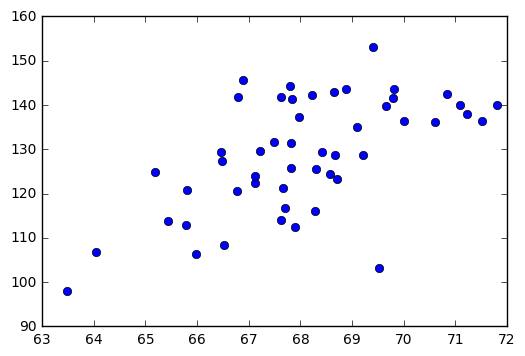

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.array(_weightRdd), np.array(_heightRdd),'o')
plt.show()

## 문제: 년별 분기별 대여건수

서울시 열린데이터 https://data.seoul.go.kr/ 서울시 공공자전거 이용현황 데이터를 분석해보자.


### 데이터 읽기

서울시 열린데이터에서 데이터 ```서울특별시_공공자전거 일별 대여건수_(2018~2019.03).csv``` 를 다운로드 받아서 저장한다.
csv 형식으로 schema는 자동 인식하도록 읽는다.
일자는 ```timestamp```로 건수는 ```integer```로 인식되었다.

In [17]:
_bicycle = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/seoulBicycleDailyCount_2018_201903.csv')

In [18]:
_bicycle.printSchema()

root
 |-- date: timestamp (nullable = true)
 |--  count: integer (nullable = true)



전체 건수는 455건, 5건의 데이터만 읽어보자.

In [55]:
_bicycle.count()

455

In [20]:
_bicycle.show(5)

+-------------------+------+
|               date| count|
+-------------------+------+
|2018-01-01 00:00:00|  4950|
|2018-01-02 00:00:00|  7136|
|2018-01-03 00:00:00|  7156|
|2018-01-04 00:00:00|  7102|
|2018-01-05 00:00:00|  7705|
+-------------------+------+
only showing top 5 rows



### 컬럼명 변경

앞서 보듯이 파일을 읽으면서 컬럼명이 인식되었는데 " count"가 맨 앞에 공백이 하나 있게 되어 변경해보자.
일단 붙여진 컬럼의 명칭을 변경하려면 ```withColumnRenamed()```를 연결하여 사용한다.

In [22]:
bicycle=_bicycle\
    .withColumnRenamed("date", "Date")\
    .withColumnRenamed(" count", "Count")

### 컬럼 만들기: substr

```substr()``` 함수는 인자가 2개로서, 앞글자 '1'은 시작 '4'는 4글자를 의미한다.

In [25]:
bicycle=bicycle.withColumn("year",bicycle.Date.substr(1, 4))

In [28]:
bicycle=bicycle.withColumn("month",bicycle.Date.substr(6, 2))

### 컬럼 만들기: F 함수

함수를 이용해 년, 월, 일 등을 추출할 수 있다.
먼저 앞서 생성된 column을 삭제하고 나서 해보자.
여러 컬럼을 삭제하기 위해서는 ```*```를 앞에 붙여 준다.
물론 하나씩 삭제할 수도 있고, 그러면 별표는 불필요하다.

In [43]:
import pyspark.sql.functions as F
bicycle = bicycle\
    .withColumn('year', F.year('date'))\
    .withColumn('month', F.month('date'))

### 년도별 대여건수 합계

In [63]:
bicycle.groupBy('year').agg({"count":"sum"}).show()

+----+----------+
|year|sum(count)|
+----+----------+
|2018|  10124874|
|2019|   1871935|
+----+----------+



### 년도별, 분기별 대여건수 합계

In [66]:
bicycle.groupBy('year').pivot('month').agg({"count":"sum"}).show()

+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|year|     1|     2|     3|     4|     5|      6|      7|      8|      9|     10|    11|    12|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|2018|164367|168741|462661|687885|965609|1207123|1100015|1037505|1447993|1420621|961532|500822|
|2019|495573|471543|904819|  null|  null|   null|   null|   null|   null|   null|  null|  null|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+



### S.4.6 JSON 파일에서 생성

* Spark example 폴더에 있는 ```people.json``` JSON 파일을 읽어서 DataFrame을 생성한다.

```python
{"name":"Michael"}
{"name":"Andy", "age":30}
{"name":"Justin", "age":19}
```

In [45]:
jfile= os.path.join(os.environ["SPARK_HOME"],\
           "examples/src/main/resources/people.json")

_myDf= spark.read.json(jfile)

```filter()```는 조건에 따라 데이터를 걸러낸다.

In [46]:
_myDf.filter(_myDf['age'] > 21).show()

+---+----+
|age|name|
+---+----+
| 30|Andy|
+---+----+



## 문제 월드컵 데이터 분석

### URL에서 JSON 읽기

웹에서 읽는 JSON은 문자열이라는 점에 유의한다. 따라서 json()함수로 변환하는 것이 필요하다.
```python
[
  {
    "Competition": "World Cup",
    "Year": 1930,
    "Team": "Argentina",
    "Number": "",
    "Position": "GK",
    "FullName": "Ãngel Bossio",
    "Club": "Club AtlÃ©tico Talleres de Remedios de Escalada",
    "ClubCountry": "Argentina",
    "DateOfBirth": "1905-5-5",
    "IsCaptain": false
  },
  {
    "Competition": "World Cup",
    ...
    "IsCaptain": false
  },
  ...
]
```

In [39]:
import requests
r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
wc=r.json()

In [40]:
print type(wc), type(wc[0])

<type 'list'> <type 'dict'>


In [41]:
wc[0]

{u'Club': u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada',
 u'ClubCountry': u'Argentina',
 u'Competition': u'World Cup',
 u'DateOfBirth': u'1905-5-5',
 u'FullName': u'\xc3ngel Bossio',
 u'IsCaptain': False,
 u'Number': u'',
 u'Position': u'GK',
 u'Team': u'Argentina',
 u'Year': 1930}

### DataFrame 생성

Python dict로부터 DataFrame을 생성하는 기능은 지원이 되지 않는다.
위 ```wc```는 JSON을 포함하는 리스트이다.

In [42]:
wcDF=spark.createDataFrame(wc)

In [43]:
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)



In [44]:
wcDF.take(1)

[Row(Club=u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada', ClubCountry=u'Argentina', Competition=u'World Cup', DateOfBirth=u'1905-5-5', FullName=u'\xc3ngel Bossio', IsCaptain=False, Number=u'', Position=u'GK', Team=u'Argentina', Year=1930)]

### RDD 생성

RDD를 통해서 DataFrame 생성하기

In [65]:
wcRdd=spark.sparkContext.parallelize(wc)

In [66]:
wcRdd.take(1)

[{u'Club': u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada',
  u'ClubCountry': u'Argentina',
  u'Competition': u'World Cup',
  u'DateOfBirth': u'1905-5-5',
  u'FullName': u'\xc3ngel Bossio',
  u'IsCaptain': False,
  u'Number': u'',
  u'Position': u'GK',
  u'Team': u'Argentina',
  u'Year': 1930}]

###  DataFrame의 shema 설정

wcRdd에서 DataFrame을 생성하려고 하면 아래와 같이 schema를 설정할 수 있다.
JSON은 key, value로 구성되어, 컬럼명을 key에서 가져올 수 있다.
실제 Rdd에서 생성하면 자동인식되어 schema가 설정된다.

```python
from pyspark.sql.types import *
wcSchema=StructType([
    StructField("Club", StringType(), True),
    StructField("ClubCountry", StringType(), True),
    StructField("Competition", StringType(), True),
    StructField("DateOfBirth", DateType(), True),
    StructField("FullName", StringType(), True),
    StructField("IsCaptain", BooleanType(), True),
    StructField("Number", IntegerType(), True),
    StructField("Position", StringType(), True),
    StructField("Team", StringType(), True),
    StructField("Year", IntegerType(), True)
])
```

In [67]:
wcDF=spark.createDataFrame(wcRdd)

In [68]:
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)



In [69]:
wcDF.take(1)

[Row(Club=u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada', ClubCountry=u'Argentina', Competition=u'World Cup', DateOfBirth=u'1905-5-5', FullName=u'\xc3ngel Bossio', IsCaptain=False, Number=u'', Position=u'GK', Team=u'Argentina', Year=1930)]

### 형변환

컬럼명 'DateOfBirth'는 'DoB'로 ```DateType()```, 컬럼명 'Number'는 'NumberInt'로 "integer" 형으로 설정하였다.
schema를 출력하면 이를 확인할 수 있다.

구분 | 의미
-----|-----
%d | 일자 1 ~ 31
%m | 월 1 ~ 12
%y | 세기 불포함 2자리 년수 00 ~ 99
%Y | 세기 포함한 4자리 년수

#### ```DateType``` 형변환

* ```datetime``` 사용

In [70]:
from datetime import datetime
print datetime.strptime("11/25/1991", '%m/%d/%Y')

1991-11-25 00:00:00


In [71]:
from pyspark.sql.functions import udf
toDate = udf(lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())

In [72]:
wcDF = wcDF.withColumn('date1', toDate(wcDF['DateOfBirth']))

In [73]:
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- date1: date (nullable = true)



* ```to_date()``` 함수

In [54]:
from pyspark.sql.functions import to_date

wcDF=wcDF.withColumn('date2', to_date(wcDF['DateOfBirth'], 'yyyy-MM-dd'))

* ```cast()```

In [74]:
from pyspark.sql.types import DateType

wcDF=wcDF.withColumn('date3', wcDF['DateOfBirth'].cast(DateType()))
wcDF=wcDF.withColumn('NumberInt', wcDF['Number'].cast("integer"))

In [75]:
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- date1: date (nullable = true)
 |-- date3: date (nullable = true)
 |-- NumberInt: integer (nullable = true)



In [76]:
wcDF=wcDF.drop('date1')

In [77]:
wcDF.take(1)

[Row(Club=u'Club Atl\xc3\xa9tico Talleres de Remedios de Escalada', ClubCountry=u'Argentina', Competition=u'World Cup', DateOfBirth=u'1905-5-5', FullName=u'\xc3ngel Bossio', IsCaptain=False, Number=u'', Position=u'GK', Team=u'Argentina', Year=1930, date3=datetime.date(1905, 5, 5), NumberInt=None)]

### 국가별 인원수

In [89]:
wcDF.groupBy(wcDF.ClubCountry).count().show()

+-----------+-----+
|ClubCountry|count|
+-----------+-----+
|   England |    4|
|   Paraguay|   93|
|     Russia|   51|
|        POL|   11|
|        BRA|   27|
|    Senegal|    1|
|     Sweden|  154|
|   Colombia|    1|
|        FRA|  155|
|        ALG|    8|
|   England |    1|
|       RUS |    1|
|     Turkey|   65|
|      Zaire|   22|
|       Iraq|   22|
|    Germany|  206|
|        RSA|   16|
|        ITA|  224|
|        UKR|   38|
|        GHA|    8|
+-----------+-----+
only showing top 20 rows



### 국가별 포지션별 인원수

In [88]:
wcDF.groupBy('ClubCountry').pivot('Position').count().show()

+-----------+----+----+----+----+----+
|ClubCountry|    |  DF|  FW|  GK|  MF|
+-----------+----+----+----+----+----+
|   England |null|null|   2|null|   2|
|   Paraguay|null|  26|  37|  10|  20|
|     Russia|null|  20|  11|   4|  16|
|        POL|null|   2|   2|   3|   4|
|        BRA|null|   7|   5|   4|  11|
|    Senegal|null|null|null|   1|null|
|     Sweden|null|  40|  47|  25|  42|
|   Colombia|null|null|   1|null|null|
|        ALG|null|   2|null|   6|null|
|        FRA|null|  46|  41|  18|  50|
|   England |null|null|null|null|   1|
|       RUS |null|null|null|   1|null|
|     Turkey|null|  20|  13|  12|  20|
|      Zaire|null|   6|   5|   3|   8|
|       Iraq|null|   6|   4|   3|   9|
|    Germany|null|  64|  51|  16|  75|
|        RSA|null|   5|   2|   3|   6|
|        UKR|null|  13|   7|   4|  14|
|        ITA|null|  74|  42|  19|  89|
|        CMR|null|   1|   1|   1|null|
+-----------+----+----+----+----+----+
only showing top 20 rows



### S.4.7 Parquet 파일 읽기, 쓰기

Parquet는 Apache Hadoop에서 사용하는 데이터 압축형식으로, JSON에서 읽어서 생성할 수 있다.

```python
-rw-r--r-- 1 jsl jsl 522 10월  7 15:27 part-r-00000-0318688b-018f-4e55-858b-b4b78ac56532.snappy.parquet
-rw-r--r-- 1 jsl jsl   0 10월  7 15:27 _SUCCESS
```

In [48]:
_myDf.write.parquet(os.path.join("data","people.parquet"))

앞서 쓰여진 parquet으로부터 읽어서 출력할 수 있다.

In [49]:
_pDf=spark.read.parquet(os.path.join("data","people.parquet"))

In [50]:
_pDf.show()

+----+-------+
| age|   name|
+----+-------+
|null|Michael|
|  30|   Andy|
|  19| Justin|
+----+-------+



## S.5 DataFrame API 사용해 보기

앞서 Pandas로 저장한 csv파일을 읽어서 DataFrame을 만들어 보자.

In [36]:
myDf = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/myDf.csv')

In [37]:
myDf.printSchema()
myDf.show()

root
 |-- _c0: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)

+---+----+-------+------+
|_c0|year|   name|height|
+---+----+-------+------+
|  0|   1|kim, js|   170|
|  1|   1|lee, sm|   175|
|  2|   2|lim, yg|   180|
|  3|   2|    lee|   170|
+---+----+-------+------+



#### withColumnRenamed

앞서 ```withCoumun()``` 명령어로 열을 추가해 보았다. ```withColumnRenamed()```으로 열의 명칭을 ```ClubCountry```에서 ```ClubNation```으로 변경해보자.

In [51]:
wcDF=wcDF.withColumnRenamed('ClubCountry','ClubNation')

In [52]:
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubNation: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- DoB: date (nullable = true)
 |-- NumberInt: integer (nullable = true)



#### 컬럼 선택

컬럼명은 아래와 같이 ```select()```로 선택할 수 있다.

컬럼 선택 | 예제 | 권고
-----|-----|-----
점 연산자로 컬럼명을 선택 | myDf.name | N
컬럼명으로 컬럼을 선택 | myDf['name'] | Y

In [54]:
myDf.name

Column<name>

In [56]:
myDf['name']

Column<name>

그러나 컬럼명으로 데이터를 조회하려면 다음과 같이 해서는 안된다. ```select()```를 사용해서 컬럼을 읽을 수 있다.

```python
myDf['name'].collect()
```

In [60]:
_name=myDf.select('name')
_name.collect()

[Row(name=u'kim, js'),
 Row(name=u'lee, sm'),
 Row(name=u'lim, yg'),
 Row(name=u'lee')]

#### Row

Row 객체의 값은 아래와 같이 단순하게 split 할 수 없으며, 오류가 발생한다. ```dict```로 변환한 후 그 값을 split해야 한다.

```python
_name.rdd.map(lambda line:[line.split(',')])
```

In [75]:
r=Row(name=u'kim, js')
rd=r.asDict()
print rd.values()[0].split(',')

[u'kim', u' js']


#### 컬럼과 행을 선택

* 행: ```where()```에 따라 컬럼의 조건에 맞는 행을 선택하고,
* 열: 앞서 배운 ```select()```로 열을 선택


In [65]:
myDf.where(myDf['height'] < 175)\
    .select(myDf['name'], myDf['height']).show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|    lee|   170|
+-------+------+



#### groupBy

컬럼을 키 값에 따라 구분하고 통계 값을 계산할 수 있다.

In [66]:
myDf.groupby(myDf['year']).max().show()

+----+-----------+
|year|max(height)|
+----+-----------+
|   1|        175|
|   2|        180|
+----+-----------+



### 사용자정의 함수 udf

UDF User Defined Functions는 사용자 정의함수로서 DataFrame의 행을 처리할 경우 유용하다.
보통 함수와 같이 함수명과 반환 값을 미리 정의해서 lambda 함수 또는 만든 함수를 사용할 수 있다.

앞서 배운 ```withColumn()```에서 udf를 호출해서 ```height``` 컬럼을 ```long```에서 ```DoubleType()```으로 만들어 보자.

In [68]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

toDoublefunc = udf(lambda x: float(x),DoubleType())
myDf = myDf.withColumn("heightD",toDoublefunc(myDf.height))

In [69]:
myDf.printSchema()

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: long (nullable = true)
 |-- heightD: double (nullable = true)



year의 문자열을 정수로 형변환 해보자

In [70]:
from pyspark.sql.functions import udf, struct
from pyspark.sql.types import IntegerType
toint=udf(lambda x:int(x),IntegerType())
myDf=myDf.withColumn("yearI",toint(myDf['year']))

In [71]:
myDf.printSchema()
myDf.show()

root
 |-- year: string (nullable = true)
 |-- name: string (nullable = true)
 |-- height: long (nullable = true)
 |-- heightD: double (nullable = true)
 |-- yearI: integer (nullable = true)

+----+-------+------+-------+-----+
|year|   name|height|heightD|yearI|
+----+-------+------+-------+-----+
|   1|kim, js|   170|  170.0|    1|
|   1|lee, sm|   175|  175.0|    1|
|   2|lim, yg|   180|  180.0|    2|
|   2|    lee|   170|  170.0|    2|
+----+-------+------+-------+-----+



In [72]:
myDf.select('yearI').show()

+-----+
|yearI|
+-----+
|    1|
|    1|
|    2|
|    2|
+-----+



대문자로 만들고 문자열로 만들어 보자.
반환값의 타잎을 ```StringType()```으로 정의하고 있다는 점에 유의하자.

In [29]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
 
def uppercase(s):
    return s.upper()

upperUdf = udf(uppercase, StringType())
myDf = myDf.withColumn("nameUpper", upperUdf(myDf['name']))
myDf.show()

+---+----+-------+------+-------+-----+---------+
|_c0|year|   name|height|heightD|yearI|nameUpper|
+---+----+-------+------+-------+-----+---------+
|  0|   1|kim, js|   170|  170.0|    1|  KIM, JS|
|  1|   1|lee, sm|   175|  175.0|    1|  LEE, SM|
|  2|   2|lim, yg|   180|  180.0|    2|  LIM, YG|
|  3|   2|    lee|   170|  170.0|    2|      LEE|
+---+----+-------+------+-------+-----+---------+



키를 175를 기준으로 이분화하고 반환값을 ```StringType()```으로 정의해보자.

In [30]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

height_udf = udf(lambda height: "taller" if height >=175 else "shorter", StringType())
heightDf=myDf.withColumn("height>175", height_udf(myDf.heightD))
heightDf.show()

+---+----+-------+------+-------+-----+---------+----------+
|_c0|year|   name|height|heightD|yearI|nameUpper|height>175|
+---+----+-------+------+-------+-----+---------+----------+
|  0|   1|kim, js|   170|  170.0|    1|  KIM, JS|   shorter|
|  1|   1|lee, sm|   175|  175.0|    1|  LEE, SM|    taller|
|  2|   2|lim, yg|   180|  180.0|    2|  LIM, YG|    taller|
|  3|   2|    lee|   170|  170.0|    2|      LEE|   shorter|
+---+----+-------+------+-------+-----+---------+----------+



#### summary statistics

column이 연산가능한 데이터타잎인 경우, 요약 값을 볼 수 있다.

In [93]:
myDf.describe().show()

+-------+------------------+------------------+------------------+
|summary|            height|           heightD|             yearI|
+-------+------------------+------------------+------------------+
|  count|                 4|                 4|                 4|
|   mean|            173.75|            173.75|               1.5|
| stddev|4.7871355387816905|4.7871355387816905|0.5773502691896257|
|    min|               170|             170.0|                 1|
|    max|               180|             180.0|                 2|
+-------+------------------+------------------+------------------+



## S.6 Spark SQL

DataFrame을 관계형 데이터베이스에서 우리가 사용하는 Sql을 사용할 수 있다. RDD는 비구조적인 경우에 사용하므로 테이블로 변환한 후 Sql을 사용하게 된다.

* Spark SQL 구성

구분 | 설명
-----|-----
Language API | Python, Java, Scala, Hive QL API를 제공
Schema RDD | RDD에 Schema를 적용해 임시 테이블로 변환한다.<br>createOrReplaceTempView<br>createGlobalTempView
Data Sources | 다양한 형식 지원 - HDFS, Cassandra, HBase, RDB

앞서 만들어 놓은 World Cup 데이터를 사용한다.

In [73]:
wcDF.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubNation: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- DoB: date (nullable = true)
 |-- NumberInt: integer (nullable = true)



이제 임시 테이블 ```wc```를 만들고, Sql문으로 데이터를 조회해보자.

In [74]:
wcDF.createOrReplaceTempView("wc")
spark.sql("select Club,Team,Year from wc").show(1)

+--------------------+---------+----+
|                Club|     Team|Year|
+--------------------+---------+----+
|Club AtlÃ©tico Ta...|Argentina|1930|
+--------------------+---------+----+
only showing top 1 row



In [77]:
wcPlayers=spark.sql("select FullName,Club,Team,Year from wc")
wcPlayers.show(1)

+------------+--------------------+---------+----+
|    FullName|                Club|     Team|Year|
+------------+--------------------+---------+----+
|Ãngel Bossio|Club AtlÃ©tico Ta...|Argentina|1930|
+------------+--------------------+---------+----+
only showing top 1 row



In [78]:
spark.catalog.listTables()

[Table(name=u'wc', database=None, description=None, tableType=u'TEMPORARY', isTemporary=True)]

```wcPlayers```를 RDD로 변환해서 이름만 출력해 보자.

In [57]:
namesRdd=wcPlayers.rdd.map(lambda x: "Full name: "+x[0])
for e in namesRdd.take(5):
    print e

Full name: Ãngel Bossio
Full name: Juan Botasso
Full name: Roberto Cherro
Full name: Alberto Chividini
Full name: 


#### sql.functions and join

리스트에 포함되어 있는 과일에 고유번호를 할당해 보자.

In [79]:
bucketDf=spark.createDataFrame([[1,["orange", "apple", "pineapple"]],
                                [2,["watermelon","apple","bananas"]]],
                               ["bucketId","items"])

In [80]:
bucketDf.show(truncate=False)

+--------+----------------------------+
|bucketId|items                       |
+--------+----------------------------+
|1       |[orange, apple, pineapple]  |
|2       |[watermelon, apple, bananas]|
+--------+----------------------------+



* explode

컬럼에 List 또는 배열이 포함된 경우 ```explode()``` 함수는 이를 flat해서 새로운 컬럼을 생성하게 된다.


In [82]:
from pyspark.sql.functions import explode
bDf=bucketDf.select(bucketDf.bucketId,explode(bucketDf.items).alias('item'))

In [83]:
bDf.show()

+--------+----------+
|bucketId|      item|
+--------+----------+
|       1|    orange|
|       1|     apple|
|       1| pineapple|
|       2|watermelon|
|       2|     apple|
|       2|   bananas|
+--------+----------+



또 다른 DataFrame을 생성해보자. 나중에 앞의 DataFrame과 join하게 된다.

In [96]:
fDf=spark.createDataFrame([["orange", "F1"],
                            ["", "F2"],
                            ["pineapple","F3"],
                            ["watermelon","F4"],
                            ["bananas","F5"]],
                            ["item","itemId"])

In [100]:
fDf.show()

+----------+------+
|      item|itemId|
+----------+------+
|    orange|    F1|
|          |    F2|
| pineapple|    F3|
|watermelon|    F4|
|   bananas|    F5|
+----------+------+



* join

join은 ```inner, cross, outer, full, full_outer, left, left_outer, right, right_outer, left_semi, left_anti``` 여러 종류가 있다. ```inner```기준으로 item이 일치하지 않는 것은 제외하게 된다.

In [98]:
joinDf=fDf.join(bDf, fDf.item==bDf.item, "inner")

In [99]:
joinDf.select(fDf.itemId,fDf.item,bDf.bucketId).show()

+------+----------+--------+
|itemId|      item|bucketId|
+------+----------+--------+
|    F5|   bananas|       2|
|    F1|    orange|       1|
|    F3| pineapple|       1|
|    F4|watermelon|       2|
+------+----------+--------+



#### agg

```agg()```는 합계 함수를 계산할 수 있으며, 지원하는 함수는 ```avg, max, min, sum, count```이다.


In [103]:
myDf.show()

+----+-------+------+-------+-----+
|year|   name|height|heightD|yearI|
+----+-------+------+-------+-----+
|   1|kim, js|   170|  170.0|    1|
|   1|lee, sm|   175|  175.0|    1|
|   2|lim, yg|   180|  180.0|    2|
|   2|    lee|   170|  170.0|    2|
+----+-------+------+-------+-----+



```how tall``` 컬럼을 조건에 따라 생성할 수 있다.

In [104]:
from pyspark.sql.functions import when
_myDf=myDf.select(when(myDf['heightD'] >175.0, ">175")\
            .otherwise("<175").alias("how tall"))
_myDf.show()

+--------+
|how tall|
+--------+
|    <175|
|    <175|
|    >175|
|    <175|
+--------+



```year``` 컬럼에 대해 ```agg()``` 함수로 계산할 수 있다.

dictionary 형식으로 key는 컬럼명, value는 합계 함수를 적어준다.
예를 들어 {"heightD":"avg"}에서 "heightD"는 컬럼명, "avg"는 합계함수이다.


In [106]:
myDf.groupBy('year').agg({"heightD":"avg"}).show()

+----+------------+
|year|avg(heightD)|
+----+------------+
|   1|       172.5|
|   2|       175.0|
+----+------------+



또는 아래와 같이 별도 ```sql.functions```을 사용할 수 있다.

In [109]:
from pyspark.sql import functions as F

myDf.agg(F.min(myDf.heightD),F.max(myDf.heightD),F.avg(myDf.heightD),F.sum(myDf.heightD)).show()

+------------+------------+------------+------------+
|min(heightD)|max(heightD)|avg(heightD)|sum(heightD)|
+------------+------------+------------+------------+
|       170.0|       180.0|      173.75|       695.0|
+------------+------------+------------+------------+



## 문제 S-1: 네트워크에 불법적으로 침입하는 사용자의 분석

### 문제

네트워크에 불법적으로 침입하는 시도는 허용되어서는 안된다.
1998년 MIT Lincoln Labs에서 DARPA Intrusion Detection Evaluation Program을 연구하였다.
이 데이터의 일부가 1999년 KDD로 만들어져 배포되고 있다.
https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

### 해결

마지막 행에 attack의 유형이 구분되어 있다. 네트워크 침입 유형의 특징을 분석해 보자.
탐지예방 모델을 구축할 수 있다.


KDD데이터는 41 항목으로 구성되어 있다.

```python
연결(초) | duration: continuous.
프로토콜 (tcp,udp,etc) | protocol_type: symbolic.
서비스 (http,telnet, etc) | service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: continuous.
dst_host_same_srv_rate: continuous.
dst_host_diff_srv_rate: continuous.
dst_host_same_src_port_rate: continuous.
dst_host_srv_diff_host_rate: continuous.
dst_host_serror_rate: continuous.
dst_host_srv_serror_rate: continuous.
dst_host_rerror_rate: continuous.
dst_host_srv_rerror_rate: continuous.
```

### RDD 생성

KDD 파일은 **gz** 압축되어 있다. 파일 확장자 'gz'은 'gzip'이라는 압축 도구에서 생성된 파일이다. 지금은 WinZip에서 읽을 수 있다.
**RDD**는 **압축파일에서 데이터를 읽어 올 수 있다**.

반면, DataFrame은 구조schema를 정의해야 하기 때문에 쉽지 않다. 여기서는 **오류**가 발생한다.
따라서 RDD를 생성하고 난 후, 그로부터 DataFrame을 생성하고, Sql을 사용한다.

파일이 로컬 디렉토리 ```data```에 존재하면, 즉 이미 내려받았으므로 또 내려받지 않는다. 그렇지 않을 경우에만 ```urlretrieve()``` 함수로 내려받는다.

In [5]:
import os
import urllib
_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
_fname = os.path.join(os.getcwd(),'data','kddcup.data_10_percent.gz')
if(not os.path.exists(_fname)):
    print "%s data does not exist! retrieving.." % _fname
    _f=urllib.urlretrieve(_url,_fname)


```textFile()``` 함수로 RDD를 생성한다. ```count()```는 행의 수를 돌려주는 action 함수이다. action 함수는 바로 실행되므로 시간이 좀 걸린다.

In [8]:
_rdd = spark.sparkContext.textFile(_fname)

In [9]:
_rdd.count()

494021

In [6]:
_rdd.take(1)

[u'0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.']

```map()``` 함수를 사용하여 csv 형식으로 구성된 파일을 컴마(,)로 분리한다.

In [10]:
_allRdd=_rdd.map(lambda x: x.split(','))

In [11]:
print _allRdd.take(1)

[[u'0', u'tcp', u'http', u'SF', u'181', u'5450', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'8', u'8', u'0.00', u'0.00', u'0.00', u'0.00', u'1.00', u'0.00', u'0.00', u'9', u'9', u'1.00', u'0.00', u'0.11', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'normal.']]


**attack 종류**는 41번째 열에 구분되어 있다. 총 494,021건을 정상 'noraml'과 나머지는 'attack'으로 구분한다.
'attack'은 크게 4종류로 나눈다. DOS는 서비스 거부, R2L 원격침입, U2R은 루트권한침입, probing은 탐지이다.

attack 4종류 | 설명 | 41번째 열
-----|-----|-----
DOS | denial-of-service, e.g. syn flood | back, land, neptune, pod, smurf, teardrop
R2L | unauthorized access from a remote machine | ftp_write, guess_passwd, imap, multihop, phf, spy, warezclient, warezmaster
U2R | unauthorized access to local superuser (root) privileges | buffer_overflow, loadmodule, perl, rootkit
probing | surveillance and other probing | ipsweep, nmap, portsweep, satan

열41에 대해 건수를 세어보자.
```reduceByKey()```는 인자로 '함수'가 필요. 키별로 '함수를 사용해서' 계산한다.

In [9]:
_41 = _allRdd.map(lambda x: (x[41], 1))
_41.reduceByKey(lambda x,y: x+y).collect()

[(u'guess_passwd.', 53),
 (u'nmap.', 231),
 (u'warezmaster.', 20),
 (u'rootkit.', 10),
 (u'warezclient.', 1020),
 (u'smurf.', 280790),
 (u'pod.', 264),
 (u'neptune.', 107201),
 (u'normal.', 97278),
 (u'spy.', 2),
 (u'ftp_write.', 8),
 (u'phf.', 4),
 (u'portsweep.', 1040),
 (u'teardrop.', 979),
 (u'buffer_overflow.', 30),
 (u'land.', 21),
 (u'imap.', 12),
 (u'loadmodule.', 9),
 (u'perl.', 3),
 (u'multihop.', 7),
 (u'back.', 2203),
 (u'ipsweep.', 1247),
 (u'satan.', 1589)]

```groupByKey()```는 키별로 group한다. 위 ```reduceByKey()```와 달리 ```mapValues()```를 사용해 값을 별도로 계산한다는 점에 유의하자.

In [10]:
_41 = _allRdd.map(lambda x: (x[41], 1))
def f(x): return len(x)
_41.groupByKey().mapValues(f).collect()

[(u'guess_passwd.', 53),
 (u'nmap.', 231),
 (u'warezmaster.', 20),
 (u'rootkit.', 10),
 (u'warezclient.', 1020),
 (u'smurf.', 280790),
 (u'pod.', 264),
 (u'neptune.', 107201),
 (u'normal.', 97278),
 (u'spy.', 2),
 (u'ftp_write.', 8),
 (u'phf.', 4),
 (u'portsweep.', 1040),
 (u'teardrop.', 979),
 (u'buffer_overflow.', 30),
 (u'land.', 21),
 (u'imap.', 12),
 (u'loadmodule.', 9),
 (u'perl.', 3),
 (u'multihop.', 7),
 (u'back.', 2203),
 (u'ipsweep.', 1247),
 (u'satan.', 1589)]

데이터가 ```normal```인 경우와 아닌 경우로 구분하자.
```filter()```는 41번째 행을 조건에 따라 데이터를 구분한다.
```count()``` 함수로 건수를 계산하면 'normal' 97,278, 'attack'은 396,743 건이다.

침입구분 | 건수
-------|-------
normal | 97278
attack | 396743
전체 | 494021

In [11]:
_normalRdd=_allRdd.filter(lambda x: x[41]=="normal.")
_attackRdd=_allRdd.filter(lambda x: x[41]!="normal.")

In [12]:
print _normalRdd.count()
print _attackRdd.count()

97278
396743


### Dataframe 생성

열 0, 1, 2, 3, 4, 5, 41을 선별하여 스키마를 정해서 RDD를 생성한다.

In [12]:
from pyspark.sql import Row

_csv = _rdd.map(lambda l: l.split(","))
_csvRdd = _csv.map(lambda p: 
    Row(
        duration=int(p[0]), 
        protocol=p[1],
        service=p[2],
        flag=p[3],
        src_bytes=int(p[4]),
        dst_bytes=int(p[5]),
        attack=p[41]
    )
)

RDD를 Dataframe으로 변환한다.


In [13]:
_df=spark.createDataFrame(_csvRdd)


In [14]:
_df.printSchema()
_df.show(5)

root
 |-- attack: string (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- duration: long (nullable = true)
 |-- flag: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- service: string (nullable = true)
 |-- src_bytes: long (nullable = true)

+-------+---------+--------+----+--------+-------+---------+
| attack|dst_bytes|duration|flag|protocol|service|src_bytes|
+-------+---------+--------+----+--------+-------+---------+
|normal.|     5450|       0|  SF|     tcp|   http|      181|
|normal.|      486|       0|  SF|     tcp|   http|      239|
|normal.|     1337|       0|  SF|     tcp|   http|      235|
|normal.|     1337|       0|  SF|     tcp|   http|      219|
|normal.|     2032|       0|  SF|     tcp|   http|      217|
+-------+---------+--------+----+--------+-------+---------+
only showing top 5 rows



### attack 분류

네트워크 침입이 'attack' 또는 'normal'에 따라 구분해서 ```attackB``` 컬럼을 생성한다.

In [15]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
attack_udf = udf(lambda x: "normal" if x =="normal." else "attack", StringType())
myDf=_df.withColumn("attackB", attack_udf(_df.attack))

In [16]:
myDf.printSchema()

root
 |-- attack: string (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- duration: long (nullable = true)
 |-- flag: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- service: string (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- attackB: string (nullable = true)



네트워크 침입 attack을 세분화하여 normal, dos, r2l, u2r, probling으로 **5종류**로 구분한다.
구분 문자열이 **점('.')**으로 끝난다는 점에 주의하다.

attack 4종류 | 설명 | 41번째 열
-----|-----|-----
DOS | denial-of-service, e.g. syn flood | back, land, neptune, pod, smurf, teardrop
R2L | unauthorized access from a remote machine | ftp_write, guess_passwd, imap, multihop, phf, spy, warezclient, warezmaster
U2R | unauthorized access to local superuser (root) privileges | buffer_overflow, loadmodule, perl, rootkit
probing | surveillance and other probing | ipsweep, nmap, portsweep, satan

위 표에 따라 ```udf()``` 함수를 사용해서 if문으로 'noraml' 및 'attack'을 총 5가지 종류로 구분한다.
반환 값은 ```StringType()```이다.

In [17]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
def classify41(s):
    _5=""
    if s=="normal.":
        _5="normal"
    elif s=="back." or s=="land." or s=="neptune." or s=="pod." or s=="smurf." or s=="teardrop.":
        _5="dos"
    elif s=="ftp_write." or s=="guess_passwd." or s=="imap." or s=="multihop." or s=="phf." or\
        s=="spy." or s=="warezclient." or s=="warezmaster.":
        _5="r2l"
    elif s=="buffer_overflow." or s=="loadmodule." or s=="perl." or s=="rootkit.":
        _5="u2r"
    elif s=="ipsweep." or s=="nmap." or s=="portsweep." or s=="satan.":
        _5="probing"
    return _5

attack5_udf = udf(classify41, StringType())

In [18]:
myDf=myDf.withColumn("attack5", attack5_udf(_df.attack))

In [19]:
myDf.printSchema()

root
 |-- attack: string (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- duration: long (nullable = true)
 |-- flag: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- service: string (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- attackB: string (nullable = true)
 |-- attack5: string (nullable = true)



잘 분류되었는지 일부 데이터를 살펴보자.

In [53]:
myDf.show(5)

+-------+---------+--------+----+--------+-------+---------+-------+-------+
| attack|dst_bytes|duration|flag|protocol|service|src_bytes|attackB|attack5|
+-------+---------+--------+----+--------+-------+---------+-------+-------+
|normal.|     5450|       0|  SF|     tcp|   http|      181| normal| normal|
|normal.|      486|       0|  SF|     tcp|   http|      239| normal| normal|
|normal.|     1337|       0|  SF|     tcp|   http|      235| normal| normal|
|normal.|     1337|       0|  SF|     tcp|   http|      219| normal| normal|
|normal.|     2032|       0|  SF|     tcp|   http|      217| normal| normal|
+-------+---------+--------+----+--------+-------+---------+-------+-------+
only showing top 5 rows



### attack, normal 특징 분석

```attack5``` 별로 건수를 세어보자.

In [54]:
myDf.groupBy('attack5').count().show()

+-------+------+
|attack5| count|
+-------+------+
|probing|  4107|
|    u2r|    52|
| normal| 97278|
|    r2l|  1126|
|    dos|391458|
+-------+------+



```attack5``` 별로 공격의 특징을 분석해보자. 어떤 ```protocol```, ```src_bytes```, ```duration```이 어떤지 계산할 수 있다.

In [55]:
myDf.groupBy("protocol").count().show()

+--------+------+
|protocol| count|
+--------+------+
|     tcp|190065|
|     udp| 20354|
|    icmp|283602|
+--------+------+



In [56]:
myDf.groupBy('attackB','protocol').count().show()

+-------+--------+------+
|attackB|protocol| count|
+-------+--------+------+
| normal|     udp| 19177|
| normal|    icmp|  1288|
| normal|     tcp| 76813|
| attack|    icmp|282314|
| attack|     tcp|113252|
| attack|     udp|  1177|
+-------+--------+------+



In [57]:
myDf.groupBy('attackB').pivot('protocol').count().show()

+-------+------+------+-----+
|attackB|  icmp|   tcp|  udp|
+-------+------+------+-----+
| normal|  1288| 76813|19177|
| attack|282314|113252| 1177|
+-------+------+------+-----+



In [58]:
myDf.groupBy('attack5').pivot('protocol').avg('src_bytes').show()

+-------+------------------+------------------+------------------+
|attack5|              icmp|               tcp|               udp|
+-------+------------------+------------------+------------------+
|probing|10.700793650793651| 261454.6003016591|25.235897435897435|
|    u2r|              null| 960.8979591836735|13.333333333333334|
| normal| 91.47049689440993|1439.3120305156679| 98.01220211711947|
|    r2l|              null|271972.57460035523|              null|
|    dos| 936.2672084368129| 1090.303422435458|              28.0|
+-------+------------------+------------------+------------------+



In [59]:
myDf.groupBy('attack5').avg('duration').show()

+-------+--------------------+
|attack5|       avg(duration)|
+-------+--------------------+
|probing|   485.0299488677867|
|    u2r|    80.9423076923077|
| normal|  216.65732231336992|
|    r2l|   559.7522202486679|
|    dos|7.254929008986916E-4|
+-------+--------------------+



In [60]:
from pyspark.sql import functions as F
myDf.groupBy('attackB').pivot('protocol').agg(F.max('dst_bytes')).show()

+-------+----+-------+---+
|attackB|icmp|    tcp|udp|
+-------+----+-------+---+
| normal|   0|5134218|516|
| attack|   0|5155468| 74|
+-------+----+-------+---+



좀 더 세밀한 조건으로 ```duration>1000)```, ```dst_bytes==0```인 경우의 건수를 계산할 수 있다.

In [61]:
myDf.select("protocol", "duration", "dst_bytes")\
    .filter(_df.duration>1000)\
    .filter(_df.dst_bytes==0)\
    .groupBy("protocol")\
    .count()\
    .show()

+--------+-----+
|protocol|count|
+--------+-----+
|     tcp|  139|
+--------+-----+



### SQL

SQL을 사용해보자. 위에 사용했던 ```_df```에서 임시 테이블 ```_tab```을 생성한다.

In [62]:
_df.registerTempTable("_tab")

In [63]:
tcp_interactions = spark.sql(
"""
    SELECT duration, dst_bytes FROM _tab
    WHERE protocol = 'tcp' AND duration > 1000 AND dst_bytes = 0
""")

In [67]:
tcp_interactions.show(5)

+--------+---------+
|duration|dst_bytes|
+--------+---------+
|    5057|        0|
|    5059|        0|
|    5051|        0|
|    5056|        0|
|    5051|        0|
+--------+---------+
only showing top 5 rows



In [65]:
tcp_interactions_out = tcp_interactions.rdd\
    .map(lambda p: "Duration: {}, Dest. bytes: {}".format(p.duration, p.dst_bytes))

In [66]:
for i,ti_out in enumerate(tcp_interactions_out.collect()):
    if(i%10==0):
        print ti_out

Duration: 5057, Dest. bytes: 0
Duration: 5043, Dest. bytes: 0
Duration: 5046, Dest. bytes: 0
Duration: 5051, Dest. bytes: 0
Duration: 5057, Dest. bytes: 0
Duration: 5063, Dest. bytes: 0
Duration: 42448, Dest. bytes: 0
Duration: 40121, Dest. bytes: 0
Duration: 31709, Dest. bytes: 0
Duration: 30619, Dest. bytes: 0
Duration: 22616, Dest. bytes: 0
Duration: 21455, Dest. bytes: 0
Duration: 13998, Dest. bytes: 0
Duration: 12933, Dest. bytes: 0


## 문제 S-2: Twitter JSON 데이터 읽기

* [nok] 현재 디렉토리 _tweet.json
    * src/ds_twitter_3.py로 변경 (ds_twitter_3.json으로 저장)



* Twitter JSON을 읽을 경우

구분 | 예
-------|-------
unicode를 사용하면 backslash | "{\"created_at\":\"Sun Nov 13 00:05:19 +0000 2016\"
보통 | {"created_at":"Sun Nov 13 00:05:19 +0000 2016"

* allowBackslashEscapingAnyCharacter

json 파일을 읽어서 DataFrame을 생성해보자.

In [20]:
t2df= spark.read.json(os.path.join("src","ds_twitter_seoul_3.json"))
print type(t2df)

<class 'pyspark.sql.dataframe.DataFrame'>


트윗의 'id','lang','text' 컬럼만을 선택해서 한 줄을 출력해보자.

In [21]:
res=t2df.select('id','lang','text').take(1)

In [22]:
for e in res:
    print e['id'],e['lang'],e['text']

801657325836763136 en RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, And Leeteuk To MC For 2016 Super Seoul Dream Concert 
https://t.co/1XRSaRBbE0 https://t.co/fi…


In [34]:
twitterDF= spark.read.json(os.path.join("src","ds_twitter_1_noquote.json"))

In [35]:
twitterDF.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- symbols: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- urls: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |-- favorite_count: long (nullable = true)
 |-- favorited: boolean (nullable = true)
 |-- geo: string (nullable = true)
 |-- id: long (nullable = true)
 |-- id_str: string (nullable = true)
 |-- in_reply_to_screen_name: string (nullable = true)
 |-- in_reply_to_status_id: string (nullable = true)
 |-- in_reply_to_status_id_str: string (nullable = true)
 |-- in_reply_to_user_id: string (nullable = true)
 |-- in_reply_to_user_id_str: s

In [36]:
twitterDF.select('text').show()

+---------------+
|           text|
+---------------+
|Hello 21 160924|
+---------------+



In [39]:
twitterDF.registerTempTable("twitter")
spark.sql("select text from twitter").show()

+---------------+
|           text|
+---------------+
|Hello 21 160924|
+---------------+



## 문제 S-3: 뉴욕에서 출생한 신생아 분석

### 뉴욕에서 출생한 신생아가 년도별 성별에 차이가 있을까?

뉴욕에서 2007년 출생한 유아의 기록이다.
https://health.data.ny.gov/Health/Baby-Names-Beginning-2007/jxy9-yhdk

Column Name | 설명
-----|-----
Year | Year data was collected.
First Name | 이름
County | Location where the baby’s mother resided as stated on their birth certificate.
Sex | F= Female M= Male
Count | Five (5) or more of the same baby name in a county outside of NYC; Ten (10) or more of the same baby name in a NYC borough.


https://catalog.data.gov/dataset

data/dataGovbabyNames.json 은 메타데이터가 있어서 kaggle.com의 baby names를 사용해서 분석?


```requests.get()``` 함수를 사용해서 url로부터 데이터를 읽어 오면 string이다 (예: ```r.iter_lines()```하면 문자 1개씩 가져옴). response를 json으로 읽으면 된다.

In [1]:
import json
import requests
_url="https://health.data.ny.gov/api/views/jxy9-yhdk/rows.json?accessType=DOWNLOAD"
_json=requests.get(_url).json()

* json데이터는 meta, data로 구분해서 만들어져 있다.
    * data는 Python List로 구성되어 있다 (앞서 Python dict에서 생성하는 경우와 비교해 본다.)
    * data의 건수는 52,252건


In [4]:
_json.keys()

[u'meta', u'data']

In [5]:
_jsonList=_json['data']
print len(_jsonList)

235510


In [6]:
_json['data'][0]

[u'row-56s8~p76n_zvtk',
 u'00000000-0000-0000-39E1-487334739D3C',
 0,
 1527713235,
 None,
 1527713235,
 None,
 u'{ }',
 u'2016',
 u'DAVID',
 u'Kings',
 u'M',
 u'231']

* Python list로부터 Spark Dataframe을 생성한다.

In [63]:
_df=spark.createDataFrame(_json['data'])
_df.count()

145570

* schema를 정하지 않았으므로 임의로 생성된 속성을 사용하고 있다.

In [52]:
_df.printSchema()

root
 |-- _1: long (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: long (nullable = true)
 |-- _4: long (nullable = true)
 |-- _5: string (nullable = true)
 |-- _6: long (nullable = true)
 |-- _7: string (nullable = true)
 |-- _8: string (nullable = true)
 |-- _9: string (nullable = true)
 |-- _10: string (nullable = true)
 |-- _11: string (nullable = true)
 |-- _12: string (nullable = true)
 |-- _13: string (nullable = true)



* 컬럼명을 새로 정의한다. 

In [ ]:

_myDf = _df.select('_9','_10','_11','_12','_13')

In [76]:
_myDf=_myDf.withColumn('count',_df['_13'].cast("integer")).drop('_13')
_myDf=_myDf.withColumnRenamed('_9','year')
_myDf=_myDf.withColumnRenamed('_10','fname')
_myDf=_myDf.withColumnRenamed('_11','county')
_myDf=_myDf.withColumnRenamed('_12','sex')
_myDf.printSchema()
_myDf.show(5)

root
 |-- year: string (nullable = true)
 |-- fname: string (nullable = true)
 |-- county: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- count: integer (nullable = true)

+----+-------+-----------+---+-----+
|year|  fname|     county|sex|count|
+----+-------+-----------+---+-----+
|2013|  GAVIN|ST LAWRENCE|  M|    9|
|2013|   LEVI|ST LAWRENCE|  M|    9|
|2013|  LOGAN|   NEW YORK|  M|   44|
|2013| HUDSON|   NEW YORK|  M|   49|
|2013|GABRIEL|   NEW YORK|  M|   50|
+----+-------+-----------+---+-----+
only showing top 5 rows



In [77]:
_myDf.filter(_myDf['fname'] == u'GAVIN').show(2)

+----+-----+-----------+---+-----+
|year|fname|     county|sex|count|
+----+-----+-----------+---+-----+
|2013|GAVIN|ST LAWRENCE|  M|    9|
|2013|GAVIN|    SUFFOLK|  M|   54|
+----+-----+-----------+---+-----+
only showing top 2 rows



* Sql을 사용할 수 있다.

In [83]:
_myDf.registerTempTable("babyNames")
spark.sql("select distinct(fname) from babyNames").show(5)

+------+
| fname|
+------+
|MILANA|
|  JADE|
|  ANNA|
|HUNTER|
|ANJALI|
+------+
only showing top 5 rows



* 년도별 성별 빈도수를 계산한다.

In [88]:
_myDf.sort('year').groupBy('year').pivot('sex').count().show()

+----+-----+-----+
|year|    F|    M|
+----+-----+-----+
|2007| 3002| 3365|
|2008| 3039| 3442|
|2009| 2917| 3395|
|2010| 2925| 3267|
|2011| 2918| 3298|
|2012| 2872| 3292|
|2013| 2836| 3322|
|2014| 4121| 4241|
|2015|50803|42515|
+----+-----+-----+



## 문제 S-4: 우버 택시의 운행기록 분석

* 질문: 2015년 가장 많은 운행을 한 base는?
https://github.com/tmcgrath/spark-with-python-course/blob/master/Spark-SQL-CSV-with-Python.ipynb

* fivethirtyeight
    * git clone https://github.com/fivethirtyeight/uber-tlc-foil-response.git
        daily Uber trip statistics in January and February 2015

dispatching_base_number | date | active_vehicles | trips
----------|----------|----------|----------
B02512 | 1/1/2015 | 190 | 1132
B02765 | 1/1/2015 | 225 | 1765


In [6]:
import os
data_home=os.path.join(os.environ['HOME'],"Code/git/else/uber-tlc-foil-response")
filePath=os.path.join(data_home,"Uber-Jan-Feb-FOIL.csv")

_rdd = spark.sparkContext.textFile(filePath)

* header는 속성 명을 가지고 있다.
* header를 제외하고 읽기

In [7]:
header = _rdd.first() #extract header
_rdd = _rdd.filter(lambda x:x != header)

print _rdd.count()
print _rdd.first()

354
B02512,1/1/2015,190,1132


* csv는 comma seperated 형식이므로, ','로 분리
* 첫번째 열에서 key값을 추출한다 (header값 포함)

In [8]:
_myRdd = _rdd.map(lambda line: line.split(","))

In [9]:
_row0keys=_myRdd.map(lambda row: row[0]).distinct().collect()

print _row0keys

[u'B02617', u'B02682', u'B02598', u'B02765', u'B02512', u'B02764']


In [101]:
_myRdd.filter(lambda row: "B02512" in row).count()

59

* B02512인 경우, trips가 2000보다 큰 레코드 수집

In [102]:
_myRdd.filter(lambda row: "B02512" in row).filter(lambda row: int(row[3])>2000).collect()

[[u'B02512', u'1/30/2015', u'256', u'2016'],
 [u'B02512', u'2/5/2015', u'264', u'2022'],
 [u'B02512', u'2/12/2015', u'269', u'2092'],
 [u'B02512', u'2/13/2015', u'281', u'2408'],
 [u'B02512', u'2/14/2015', u'236', u'2055'],
 [u'B02512', u'2/19/2015', u'250', u'2120'],
 [u'B02512', u'2/20/2015', u'272', u'2380'],
 [u'B02512', u'2/21/2015', u'238', u'2149'],
 [u'B02512', u'2/27/2015', u'272', u'2056']]

In [103]:
_myRdd.map(lambda x: (x[0], int(x[3]))).reduceByKey(lambda k,v: k + v).collect()

[(u'B02617', 725025),
 (u'B02682', 662509),
 (u'B02598', 540791),
 (u'B02765', 193670),
 (u'B02512', 93786),
 (u'B02764', 1914449)]

In [ ]:
def countPartitions(id,iterator): 
    c = 0 
    for _ in iterator: 
        c += 1
    yield (id,c) 
_wc=wc.mapPartitions(countPartitions)

In [104]:
_df=spark.createDataFrame(_myRdd)
print _df.count()
print _df.show(3)
print _df.printSchema()

354
+------+--------+----+-----+
|    _1|      _2|  _3|   _4|
+------+--------+----+-----+
|B02512|1/1/2015| 190| 1132|
|B02765|1/1/2015| 225| 1765|
|B02764|1/1/2015|3427|29421|
+------+--------+----+-----+
only showing top 3 rows

None
root
 |-- _1: string (nullable = true)
 |-- _2: string (nullable = true)
 |-- _3: string (nullable = true)
 |-- _4: string (nullable = true)

None


In [105]:
_myDf=_df.withColumn('trips',_df['_4'].cast("integer")).drop('_4')
_myDf=_myDf.withColumnRenamed('_1','baseNum')
_myDf=_myDf.withColumnRenamed('_2','date')
_myDf=_myDf.withColumnRenamed('_3','activeVechicles')
_myDf.printSchema()
_myDf.show(5)

root
 |-- baseNum: string (nullable = true)
 |-- date: string (nullable = true)
 |-- activeVechicles: string (nullable = true)
 |-- trips: integer (nullable = true)

+-------+--------+---------------+-----+
|baseNum|    date|activeVechicles|trips|
+-------+--------+---------------+-----+
| B02512|1/1/2015|            190| 1132|
| B02765|1/1/2015|            225| 1765|
| B02764|1/1/2015|           3427|29421|
| B02682|1/1/2015|            945| 7679|
| B02617|1/1/2015|           1228| 9537|
+-------+--------+---------------+-----+
only showing top 5 rows



In [106]:
_myDf.groupBy('baseNum','trips').count().show()

+-------+-----+-----+
|baseNum|trips|count|
+-------+-----+-----+
| B02682|13355|    1|
| B02765| 2623|    1|
| B02617|12016|    1|
| B02764|36318|    1|
| B02682| 4414|    1|
| B02617| 4325|    1|
| B02764|31173|    1|
| B02617|10664|    1|
| B02598|11897|    1|
| B02617|11401|    1|
| B02512| 1831|    1|
| B02765| 7658|    1|
| B02617|13688|    1|
| B02764|31957|    1|
| B02682| 8010|    1|
| B02764|33756|    1|
| B02512| 2056|    1|
| B02512|  791|    1|
| B02512| 2380|    1|
| B02598| 2957|    1|
+-------+-----+-----+
only showing top 20 rows



## 문제 S-5: JDBC를 사용해서 데이터 읽기

* jdbc를 연결하는 방식은 Java와 같이 'driver', 'url'을 설정하면 된다.
* 여기서는 sqlite를 실습한다.

* sqlite와 같이 Spark 패키지가 없는 경우, jar를 다운로드하고
설정파일 conf/spark-defaults.conf에 'spark.driver.extraClassPath'를 추가한다.


In [13]:
print spark.conf.get('spark.driver.extraClassPath')

/home/jsl/Code/git/bb/jsl/pyds/lib/sqlite-jdbc-3.14.2.jar


In [12]:
df=spark.read.format('jdbc')\
    .options(
        url="jdbc:sqlite:/home/jsl/Code/git/bb/sd/src/ds_sql_hello.db",
        dbtable="customer",
        driver="org.sqlite.JDBC"
    ).load()

df.show()

+---+------+
|cid|c_name|
+---+------+
|  1|   Kim|
+---+------+



### MySql

* Spark 패키지를 제공하지 않는다. jar를 'spark.driver.extraClassPath'에 추가하고 사용한다.

* 읽기
```python
dfmysql = sqlContext.read.format('jdbc')\
        .options(
          url='jdbc:mysql://localhost/database_name',
          driver='com.mysql.jdbc.Driver',
          dbtable='SourceTableName',
          user='your_user_name',
          password='your_password')\
        .load()
```

* 쓰기
```python
destination_df.write.format('jdbc')\
        .options(
          url='jdbc:mysql://localhost/database_name',
          driver='com.mysql.jdbc.Driver',
          dbtable='DestinationTableName',
          user='your_user_name',
          password='your_password')\
        .mode('append')\
        .save()
```

```python
bin/spark-submit --jars mysql-connector-java-5.1.40-bin.jar
      /path_to_your_program/spark_database.py
```

## S.7 MongoDB Spark connector

* Spark에서 MongoDB에 저장된 데이터를 읽어 온다.
* 참조: pymongo-spark (Spark와 PyMongo를 사용하는 Python 라이브러리, 설치하려면 pip install pymongo-spark)


### S.7.1 설정

* 참조 https://docs.mongodb.com/spark-connector/
* 설정파일 conf/spark-defaults.conf 수정
    * Spark 버전에 맞는 jar를 선택한다.
    * MongoDB<3.2인 경우, spark.mongodb.input.partitioner가 필요하다.
    * packages 여러 개를 넣을 경우에는 컴마로 분리한다.

```python
$vim conf/spark-defaults.conf 
spark.jars.packages=org.mongodb.spark:mongo-spark-connector_2.10:1.1.0
spark.mongodb.input.partitioner=MongoPaginateBySizePartitioner
```

In [32]:
print spark.conf.get('spark.jars.packages')

graphframes:graphframes:0.4.0-spark2.0-s_2.11,org.mongodb.spark:mongo-spark-connector_2.10:2.0.0,com.databricks:spark-csv_2.11:1.5.0


### S.7.2 uri

* SparkSession에 uri를 설정할 수 있다. 연결에 필요한 ip, database, collection을 정의한다.

```python
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/myDB.ds_spark_df_mongo") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/myDB.ds_spark_df_mongo") \
    .getOrCreate()
```

* 또는 실행시점에 설정할 수 있다 (아래 참조)


### S.7.3 MongoDB Python API

* format은 "com.mongodb.spark.sql.DefaultSource"로 설정한다.
* 'option'을 사용해서 실행시점에 Database, Colleciton 명을 설정할 수 있다.

구분 | 명령어 예
-----|-----
쓰기 | DataFrame.write.format("com.mongodb.spark.sql.DefaultSource")\<br>.mode("overwrite")\<br>.option("uri","mongodb://127.0.0.1/myDB.ds_spark_ml")\<br>.save()
읽기 | spark.read.format("com.mongodb.spark.sql.DefaultSource")\<br>.option("uri","mongodb://127.0.0.1/ds_twitter.seoul")\<br>.load()


### S.7.4 연습으로 쓰기, 읽기

In [33]:
people = spark.createDataFrame([("kim",10),("lee",20),("choi",30),("park",40)],["name", "age"])

In [34]:
people.write.format("com.mongodb.spark.sql.DefaultSource")\
    .mode("append")\
    .option("uri","mongodb://127.0.0.1/myDB.ds_spark_ml")\
    .save()

In [35]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
    .option("uri","mongodb://127.0.0.1/myDB.ds_spark_ml")\
    .load()

In [36]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- age: long (nullable = true)
 |-- name: string (nullable = true)



In [38]:
df.select('name').show(3)

+----+
|name|
+----+
| kim|
| lee|
|choi|
+----+
only showing top 3 rows



In [3]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
    .option("uri","mongodb://127.0.0.1/ds_twitter.seoul")\
    .load()
df.select('text').show(5)

+--------------------+
|                text|
+--------------------+
|RT @always_gd: #B...|
|RT @InfiniteUpdat...|
|RT @InfiniteUpdat...|
|RT @PartOfJimin: ...|
|RT @MHDEFB: มาแล้...|
+--------------------+
only showing top 5 rows



In [4]:
df.columns

['_id',
 'contributors',
 'coordinates',
 'created_at',
 'entities',
 'extended_entities',
 'favorite_count',
 'favorited',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'metadata',
 'place',
 'possibly_sensitive',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'user']

## S.8 spark-submit

* spark-submit는 일괄실행 (self-contained app in quick-start 참조)

* MongoDB를 사용하려면, spark-defaults.conf에 jar를 추가한다 (앞서 미리 설정하였다.)

* spark-submit을 실행하기 전, 'conf/log4j.properties'를 수정 log level을 ERROR로 설정하였다.
```python
log4j.rootCategory=ERROR, console
```

### S.8.1 간단한 작업

* DataFrame 만들고, 출력하기


In [42]:
%%writefile src/ds_spark_sql.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark

def doIt():
    d = [{'name': 'Alice', 'age': 1}]
    print spark.createDataFrame(d).collect()

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


Overwriting src/ds_spark_sql.py


In [44]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_sql.py

Ivy Default Cache set to: /home/jsl/.ivy2/cache
The jars for the packages stored in: /home/jsl/.ivy2/jars
:: loading settings :: url = jar:file:/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
org.mongodb.spark#mongo-spark-connector_2.10 added as a dependency
com.databricks#spark-csv_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent;1.0
	confs: [default]
	found graphframes#graphframes;0.4.0-spark2.0-s_2.11 in spark-packages
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found org.mongodb.spark#mongo-spark-connector_2.10;2.0.0 in central
	found org.mongodb#mongo-java-driver;3.2.2 in central
	found com.databricks#spark-csv_2.11;1.5.0 in cent

### S.8.2 MongoDB

* Database, Collection 읽기, 쓰기

In [71]:
%%writefile src/ds_spark_mongo.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark
def doIt():
    print "---------RESULT-----------"
    print "------mongodb write-------"
    myRdd = spark.sparkContext.parallelize([
        ("js", 150),
        ("Gandalf", 1000),
        ("Thorin", 195),
        ("Balin", 178),
        ("Kili", 77),
        ("Dwalin", 169),
        ("Oin", 167),
        ("Gloin", 158),
        ("Fili", 82),
        ("Bombur", None)
    ])
    myDf = spark.createDataFrame(myRdd, ["name", "age"])
    print myDf
    myDf.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()
    print "---------read-----------"
    df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
    print df.printSchema()
    df.registerTempTable("myTable")
    myTab = spark.sql("SELECT name, age FROM myTable WHERE age >= 100")
    myTab.show()

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/myDB.ds_spark_df_mongo") \
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/myDB.ds_spark_df_mongo") \
        .getOrCreate()
    doIt()
    spark.stop()


Overwriting src/ds_spark_mongo.py


In [45]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_mongo.py

Ivy Default Cache set to: /home/jsl/.ivy2/cache
The jars for the packages stored in: /home/jsl/.ivy2/jars
:: loading settings :: url = jar:file:/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
org.mongodb.spark#mongo-spark-connector_2.10 added as a dependency
com.databricks#spark-csv_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent;1.0
	confs: [default]
	found graphframes#graphframes;0.4.0-spark2.0-s_2.11 in spark-packages
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found org.mongodb.spark#mongo-spark-connector_2.10;2.0.0 in central
	found org.mongodb#mongo-java-driver;3.2.2 in central
	found com.databricks#spark-csv_2.11;1.5.0 in cent

## 문제 S-6: MongoDB 저장된 열린데이터 읽어오는 spark-submit

* MongoDB에 저장된 데이터 읽기

구분 | 명
-----|-----
Database | ds_open_subwayPassengersDb
Collection | db_open_subwayTable
key | JSON 계층구조를 따라 읽는다. CardSubwayStatisticsService.row.RIDE_PASGR_NUM

* MongoDB shell

```python
$ mongo
> use ds_open_subwayPassengersDb
switched to db ds_rest_subwayPassengers_mongo_db
> show tables
db_open_subwayTable
system.indexes
> db.db_open_subwayTable.find().limit(1)
{ "_id" : ObjectId("57fa386ff5e6e94359c033e9"), "CardSubwayStatisticsService" : { "row" : [ { "COMMT" : "", "RIDE_PASGR_NUM" : 111275, "WORK_DT" : "20130723", "LINE_NUM" : "중앙선", "SUB_STA_NM" : "용문", "ALIGHT_PASGR_NUM" : 108878, "USE_MON" : "201306" }, { "COMMT" : "", "RIDE_PASGR_NUM" : 11495, "WORK_DT" : "20130723", "LINE_NUM" : "중앙선", "SUB_STA_NM" : "원덕", "ALIGHT_PASGR_NUM" : 10964, "USE_MON" : "201306" }, { "COMMT" : "", "RIDE_PASGR_NUM" : 118103, "WORK_DT" : "20130723", "LINE_NUM" : "중앙선", "SUB_STA_NM" : "양평", "ALIGHT_PASGR_NUM" : 116604, "USE_MON" : "201306" }, { "COMMT" : "", "RIDE_PASGR_NUM" : 10590, "WORK_DT" : "20130723", "LINE_NUM" : "중앙선", "SUB_STA_NM" : "오빈", "ALIGHT_PASGR_NUM" : 10020, "USE_MON" : "201306" }, { "COMMT" : "", "RIDE_PASGR_NUM" : 26304, "WORK_DT" : "20130723", "LINE_NUM" : "중앙선", "SUB_STA_NM" : "아신", "ALIGHT_PASGR_NUM" : 26358, "USE_MON" : "201306" } ], "RESULT" : { "MESSAGE" : "정상 처리되었습니다", "CODE" : "INFO-000" }, "list_total_count" : 530 } }
```

* MongoDB에서 읽기

In [53]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
    .option("uri","mongodb://127.0.0.1/ds_open_subwayPassengersDb.db_open_subwayTable")\
    .load()
print df.printSchema()

root
 |-- CardSubwayStatisticsService: struct (nullable = true)
 |    |-- row: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- COMMT: string (nullable = true)
 |    |    |    |-- RIDE_PASGR_NUM: double (nullable = true)
 |    |    |    |-- WORK_DT: string (nullable = true)
 |    |    |    |-- LINE_NUM: string (nullable = true)
 |    |    |    |-- SUB_STA_NM: string (nullable = true)
 |    |    |    |-- ALIGHT_PASGR_NUM: double (nullable = true)
 |    |    |    |-- USE_MON: string (nullable = true)
 |    |-- RESULT: struct (nullable = true)
 |    |    |-- MESSAGE: string (nullable = true)
 |    |    |-- CODE: string (nullable = true)
 |    |-- list_total_count: integer (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)

None


In [54]:
df.registerTempTable("mySubway")
myTab = spark.sql("SELECT CardSubwayStatisticsService.row.RIDE_PASGR_NUM FROM mySubway")
#print type(myTab)
print myTab.show()
print myTab.first()
print myTab.head()

+--------------------+
|      RIDE_PASGR_NUM|
+--------------------+
|[111275.0, 11495....|
|[30281.0, 10832.0...|
|[75553.0, 189783....|
|[62789.0, 220544....|
|[74486.0, 152381....|
|[43418.0, 413533....|
|[301856.0, 37978....|
|[146909.0, 227066...|
|[152275.0, 285263...|
|[161298.0, 117720...|
|[95996.0, 39150.0...|
|[59900.0, 201035....|
|[228737.0, 108938...|
|[164574.0, 481998...|
|[748205.0, 817657...|
|[206631.0, 188076...|
|[112991.0, 111791...|
|[225105.0, 938296...|
|[175909.0, 271844...|
|[45047.0, 126837....|
+--------------------+

None
Row(RIDE_PASGR_NUM=[111275.0, 11495.0, 118103.0, 10590.0, 26304.0])
Row(RIDE_PASGR_NUM=[111275.0, 11495.0, 118103.0, 10590.0, 26304.0])


In [50]:
%%writefile src/ds_spark_subway.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark
def doIt():
    print "---------read-----------"
    df=spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
    #df = sqlContext.read.format("com.mongodb.spark.sql.DefaultSource").load()
    print df.printSchema()
    df.registerTempTable("mySubway")
    myTab = spark.sql("SELECT CardSubwayStatisticsService.row.RIDE_PASGR_NUM FROM mySubway")
    #print type(myTab)
    print myTab.show()
if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/ds_open_subwayPassengersDb.db_open_subwayTable") \
        .getOrCreate()
    doIt()
    spark.stop()


Overwriting src/ds_spark_subway.py


In [51]:
!/home/jsl/Downloads/spark-1.6.0-bin-hadoop2.6/bin/spark-submit src/ds_spark_subway.py

Ivy Default Cache set to: /home/jsl/.ivy2/cache
The jars for the packages stored in: /home/jsl/.ivy2/jars
:: loading settings :: url = jar:file:/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
graphframes#graphframes added as a dependency
org.mongodb.spark#mongo-spark-connector_2.10 added as a dependency
com.databricks#spark-csv_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent;1.0
	confs: [default]
	found graphframes#graphframes;0.4.0-spark2.0-s_2.11 in spark-packages
	found com.typesafe.scala-logging#scala-logging-api_2.11;2.1.2 in central
	found com.typesafe.scala-logging#scala-logging-slf4j_2.11;2.1.2 in central
	found org.scala-lang#scala-reflect;2.11.0 in central
	found org.slf4j#slf4j-api;1.7.7 in central
	found org.mongodb.spark#mongo-spark-connector_2.10;2.0.0 in central
	found org.mongodb#mongo-java-driver;3.2.2 in central
	found com.databricks#spark-csv_2.11;1.5.0 in cent

In [3]:
import os
print os.environ['HOME']

/home/jsl


In [ ]:
filen="국내유학중인%2B외국인유학생%2B데이터%282016년%2B12월기준%29.csv"
filen="OverseasStudentsInKorea20161229.csv"
myRdd=spark.sparkContext.textFile(os.path.join(os.environ['HOME'],"Public",filen))

In [24]:
data=myRdd.first()
for i in data.split(','):
    print i
print type(i)

����
����
������
ü���ڰ�
�б���
ü���� �õ�
ü���� �ñ���
<type 'unicode'>


In [16]:
df = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load(os.path.join(os.environ['HOME'],"Public",filen))



In [18]:
df.printSchema()

root
 |-- ����: string (nullable = true)
 |-- ����: string (nullable = true)
 |-- ������: string (nullable = true)
 |-- ü���ڰ�: string (nullable = true)
 |-- �б���: string (nullable = true)
 |-- ü���� �õ�: string (nullable = true)
 |-- ü���� �ñ���: string (nullable = true)

